<a href="https://colab.research.google.com/github/1088johny/rainfall_validation_for_uy/blob/main/Dashboard_estaciones_analisis_3_0_Mathplot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init

In [ ]:
# Load google drive files
def _init():
  !pip install gdown
  dir_notebook = "/content/notebook"
  !mkdir -p $dir_notebook
  #https://colab.research.google.com/drive/12Dp6v-hYyfuFiSibImJJx6xgvrHnEB_t?usp=sharing
  !gdown https://drive.google.com/uc?id=12Dp6v-hYyfuFiSibImJJx6xgvrHnEB_t -O $dir_notebook"/dashboard_common.ipynb"
  %run $dir_notebook"/dashboard_common.ipynb"

In [ ]:
_init()


Downloading...
From: https://drive.google.com/uc?id=12Dp6v-hYyfuFiSibImJJx6xgvrHnEB_t
To: /content/notebook/dashboard_common.ipynb
100% 50.6k/50.6k [00:00<00:00, 53.4MB/s]
     |████████████████████████████████| 9.6 MB 7.3 MB/s 
     |████████████████████████████████| 357 kB 50.0 MB/s 
     |████████████████████████████████| 3.6 MB 3.7 MB/s 
     |████████████████████████████████| 210 kB 5.6 MB/s 


/content/notebook/dashboard_common.ipynb:17: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
/content/notebook/dashboard_common.ipynb:19: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`


     |████████████████████████████████| 281.4 MB 32 kB/s 
     |████████████████████████████████| 198 kB 11.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=b021228356dbc665dfc28233f5ecd9549c4e42dcd244c57dcbab85c58e08eb5b
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


# Libreria

In [ ]:
import matplotlib as mlt
import matplotlib.pyplot as plt
import seaborn as sns 

In [ ]:
dir_drive_db = "/content/drive/MyDrive/ValidacionProductosSatelitales(VPS)/04BaseDeDatos/"

In [ ]:
def getEstacionesPerformance(df_ep, gauge):
  df_p = df_ep.reset_index().groupby(['estacion']).sum()
  df_p['missing_month_perc_'+gauge] = df_p['missing_month_'+gauge] / df_p['count_month'] 

  performance = [] 
  for perc in np.linspace(0,10,50): #range(0, 10, 1):
    df_ = df_p[ df_p['missing_month_perc_'+gauge] >=  (perc/100) ] 
    performance.append([perc, df_.shape[0], df_p.shape[0] - df_.shape[0], df_p.shape[0]])
    # display(['Total de registros ',df_.shape, ' con perdidas > ' ,perc, '% =>', round(df_.shape[0] /  df_p.shape[0], 3) ])
  performance = pd.DataFrame(performance, columns =['perc','count_above_threshold_estaciones','count_below_threshold_estaciones', 'total_estaciones'])
  performance.set_index('perc', inplace=True)

  return performance

In [ ]:
def getEstacionesByPercentageTreshold(df_, gauge, threshould_perc=0.03):
  # Accumulated  Missing  Register by Estation
  df_p = df_.reset_index().groupby(['estacion']).sum() # .sort_values('missing_month_'+gauge, ascending=False)

  # ----------------------------------------------------------------------------
  df_p['missing_month_perc_'+gauge] = df_p['missing_month_'+gauge] / df_p['count_month'] 

  # ----------------------------------------------------------------------------
  df_estaciones = df_p.reset_index()['estacion'].unique()
  df_estaciones = pd.Series(df_estaciones)

  # ----------------------------------------------------------------------------
  df_above_threshold = df_p[ df_p['missing_month_perc_'+gauge] >=  threshould_perc ] # alguna fue mayor del 3%
  df_above_threshold.sort_values('missing_month_perc_'+gauge, ascending=False)

  df_estaciones_above_threshold = df_above_threshold.reset_index()['estacion'].unique()

  # ----------------------------------------------------------------------------
  df_estaciones_below_threshold = df_estaciones[~df_estaciones.isin(df_estaciones_above_threshold)]
  
  
  return df_estaciones_below_threshold, df_estaciones_above_threshold

In [ ]:
def calculateAccuracyMetrics(df_p, gauge):
  metrics = []
  for satellite in ['imerg_final', 'imerg_late', 'chirps','persiann']:
    _cc   = __cc(df_p['accum_month_'+gauge], df_p['accum_month_'+satellite])
    _rmse = __rmse(df_p['accum_month_'+gauge], df_p['accum_month_'+satellite])
    _rb   = __rb(df_p['accum_month_'+gauge], df_p['accum_month_'+satellite])  
    metrics.append([satellite, _cc, _rmse, _rb])

  return pd.DataFrame(metrics, columns =['satellite','cc','rmse', 'rb'])

In [ ]:
def calculateAccuracyPerformance(df_p, gauge, threshold):
  metrics = []
  for satellite in ['imerg_final', 'imerg_late', 'chirps','persiann']:
    _pod = __pod(df_p['accum_month_'+gauge], df_p['accum_month_'+satellite], threshold)
    _far = __far(df_p['accum_month_'+gauge], df_p['accum_month_'+satellite], threshold)
    
    metrics.append([satellite, _pod, _far])

  return pd.DataFrame(metrics, columns =['satellite','pod','far'])

In [ ]:
def calculateMonthlyAccum(df_p, gauge):
  # ------------------------------------------------------------------------------
  # Monthly Acummulated Precipitation
  accum_month = df_p.set_index(['estacion','year', 'month']).groupby(['estacion','year', 'month']).sum()

  df_p_eym = accum_month[[gauge,'imerg_final','imerg_late','chirps','persiann']]

  df_p_eym.rename(columns = {
      gauge: 'accum_month_'+gauge,
      'imerg_final': 'accum_month_imerg_final',
      'imerg_late': 'accum_month_imerg_late',
      'chirps': 'accum_month_chirps',
      'persiann': 'accum_month_persiann'}, inplace = True)

  # ------------------------------------------------------------------------------
  # Count Total register by estation, year, month (puede ser que no este completa en un mes)
  count = df_p.set_index(['estacion','year', 'month']).groupby(['estacion','year', 'month']).count()
  df_p_eym['count_month'] = count['date']
  
  # ------------------------------------------------------------------------------
  # Count Missing
  missing = df_p.set_index(['estacion','year', 'month']).isnull().groupby(['estacion','year', 'month']).sum()
  _cols = ['missing_month_'+gauge,'missing_month_imerg_final','missing_month_imerg_late','missing_month_chirps','missing_month_persiann']
  df_p_eym[_cols] = missing[[gauge,'imerg_final','imerg_late','chirps','persiann']]

  return df_p_eym

In [ ]:
def calcuteMontlyMetrics(df_p, gauge):
  df_ute_metrics = None
  month_names = ['','JAN','FEB','MAR',
                 'APR','MAY','JUN',
                 'JUL','AUG','SEP',
                 'OCT','NOV','DEC']
  for month in range(1,13):
    df_m = df_p.query('month in [@month]')
    df_m.sort_index(inplace=True)
    _acc = calculateAccuracyMetrics(df_m, gauge)
    _acc['month'] = month
    _acc['month_name'] = month_names[month]

    if df_ute_metrics is None:
      df_ute_metrics = _acc
    else:
      df_ute_metrics = df_ute_metrics.append(_acc)

  return df_ute_metrics

In [ ]:
def calcutePerformance(df_p, gauge, r_from=10, r_to=800, step=25):
  df_ute_performance = None

  for threshold in range(r_from, r_to, step): 
    _acc = calculateAccuracyPerformance(df_p,gauge, threshold)
    _acc['threshold'] = threshold
    
    if df_ute_performance is None:
      df_ute_performance = _acc
    else:
      df_ute_performance = df_ute_performance.append(_acc)

  return df_ute_performance

## Matplotlib

In [ ]:
global_colors = {      
    'ute':      COLOR_UTE,
    'inumet':      COLOR_INUMET,
    'chirps':      COLOR_CHIRPS,
    'imerg_final': COLOR_IMERG_LATE,
    'imerg_late':  COLOR_IMERG_FINAL,
    'persiann':    COLOR_PERSIANN,
    
    'accum_month_ute':      COLOR_UTE,
    'accum_month_inumet':      COLOR_INUMET,
    'accum_month_chirps':      COLOR_CHIRPS,
    'accum_month_imerg_final': COLOR_IMERG_LATE,
    'accum_month_imerg_late':  COLOR_IMERG_FINAL,
    'accum_month_persiann':    COLOR_PERSIANN,

    'cc':   'rgb(255 , 0, 0)',
    'rmse': 'rgb(10, 112, 24)',
    'rb':   'rgb(0 , 0, 255)', 

}

global_style = {      
    'ute':      '-',
    'inumet':   '--',
}

global_linewidth = {      
    'ute':      3.0,
    'inumet':   1.5,
}



global_labels =  {      
    'ute':      'UTE',
    'inumet':      'INUMET',
    'chirps':      'Chirps',
    'imerg_final': 'Imerg Final',
    'imerg_late':  'Imerg Late',
    'persiann':    'Persiann',
    
    'accum_month_ute':         'Monthly Accumulated Gauge',
    'accum_month_inumet':      'Monthly Accumulated Gauge',
    'accum_month_chirps':      'Monthly Accumulated Chirps',
    'accum_month_imerg_final': 'Monthly Accumulated Imerg Final',
    'accum_month_imerg_late':  'Monthly Accumulated Imerg Late',
    'accum_month_persiann':    'Monthly Accumulated Persiann',

    'cc':   'CC',
    'rmse': 'RMSE',
    'rb':   'RB', 

}

In [ ]:
def get_rbg_color(val):
  vals = val.replace('rgb','').replace('(','').replace(')','').split(',')
  vals = [int(i) / 255 for i in vals]
  return  vals 

In [ ]:

SMALL_SIZE = 8*2
MEDIUM_SIZE = 10*2
BIGGER_SIZE = 12*2

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

global_path_handles = []
global_path_labels = []

def init_plot(
              nrows=1, ncols=1,
              xticks=None, yticks=None,
              xlim=None, ylim=None,
              figsize=[15,5]
              ):  
  global global_path_handles, global_path_labels

  global_path_handles = []
  global_path_labels = []

  fig, axs = plt.subplots(nrows, ncols)
  # fig.subplots_adjust(right=0.75)

  fig.set_figwidth(figsize[0])
  fig.set_figheight(figsize[1])

  # configure all axes at same
  # for axs_row in axs:
  #   for axs_col in axs_row:
  for i in range(len(fig.axes)):
        # col.plot(x, y)
        if xticks is not None:
            fig.axes[i].set_xticks(xticks)
        
        if yticks is not None:
            fig.axes[i].set_yticks(yticks) 

        
        if ylim is not None:
            fig.axes[i].set_ylim(ylim[0], ylim[1])

        if xlim is not None:
            fig.axes[i].set_xlim(xlim[0], xlim[1])        
  return fig, axs




In [ ]:
def show_plot(fig,
              title=None, xlabel=None, ylabel=None,  
              legend=None, legend_title=None, skip_legend=False, bbox_to_anchor=[1.1, 1]
              ):
  global global_path_handles, global_path_labels
  # for axs_row in axs:
  #   for axs_col in axs_row:
        
  # if legend is not None:
  #   plt.legend(legend)

  for i in range(len(fig.axes)):
    fig.axes[i].grid( b=True,  color='#a1a1a1', linestyle='-', alpha=0.2)
    fig.axes[i].margins(0,0)

    if title is not None:
      fig.axes[i].set_title(title)

    if xlabel is not None:
      fig.axes[i].set_xlabel(xlabel)
    
    if ylabel is not None:
      fig.axes[i].set_ylabel(ylabel)
 
  # # plt.legend(loc=(1.04,0.80))
  # if not skip_legend: 
  #   plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

  plt.legend( handles=global_path_handles, 
              labels=global_path_labels,
              title=legend_title,
              bbox_to_anchor = (bbox_to_anchor[0], bbox_to_anchor[1]))
  
  plt.show()

### set_ax

In [ ]:
def set_ax(fig, ax, gauge, ylabel, label, color=None, ylim=None, yticks=None, linewidth=None, style=None ):
  global global_path_handles, global_path_labels

  if color is None:
    color = get_rbg_color(global_colors[gauge])

  if style is None:
    style = global_style[gauge]
  
  if linewidth is None:
    linewidth = global_linewidth[gauge]

  # Lines ----------------------------------------------------------------------
  _len = len(ax.lines) - 1 
  ax.lines[_len].set_linestyle(style)
  ax.lines[_len].set_color(color)
  ax.lines[_len].set_linewidth(linewidth)

  # Label ----------------------------------------------------------------------
  ax.set_ylabel(ylabel)
  ax.yaxis.label.set_color(color)
  

  # Legend ----------------------------------------------------------------------
  ax.get_legend().remove() 
  
  # Tick ----------------------------------------------------------------------
  ax.tick_params(axis='y', colors=color, size=4, width=1.5)
  # ax.legend(bbox_to_anchor=(1.10,1), loc="upper left", title="UTE vs SBPP")

  if ylim is not None:
    ax.set_ylim(ylim[0], ylim[1])

  if yticks is not None:
    ax.set_yticks(np.arange(yticks[0], yticks[1], yticks[2]))

  # Global legend --------------------------------------------------------------
  global_path_handles.append(Line2D([0], [0], color=color, linewidth=linewidth, linestyle=style)) 
  global_path_labels.append(label)


In [ ]:
def set_tick(fig, ax, gauge, ylabel, color=None):
    
    # Label ----------------------------------------------------------------------
    ax.set_ylabel(ylabel)
    if color is None:
      color = get_rbg_color(global_colors[gauge])

    ax.yaxis.label.set_color(color)
    ax.tick_params(axis='y', colors=color, size=4, width=1.5)
        
 


# Pluviometros

## Data

### UTE


In [ ]:
gauge = 'ute'
f = {
    'date_from': '2001-01-01', 'date_to': '2020-12-31', 
}
df_ute = get_dataframe(gauge, f)
df_ute['date'] = pd.to_datetime(df_ute['date'], format='%Y-%m-%d')
df_ute[:1]

id               estacion  \
date                                                                  
2004-10-16  abb64642358c7cbf78f25dab3ef08d49  Paso de los Cuadrados   

                 date  ute  imerg_final  imerg_late    chirps  persiann  \
date                                                                      
2004-10-16 2004-10-16  0.0    21.202723   27.515362  32.99156       7.0   

            year_perc_nulls_ute  year_perc_nulls_chirps  ...  \
date                                                     ...   
2004-10-16            28.571429                    15.0  ...   

            month_perc_nulls_chirps  month_perc_nulls_imerg_final  \
date                                                                
2004-10-16                33.333333                           0.0   

            month_perc_nulls_imerg_late        lat        lon    alt  year  \
date                                                                         
2004-10-16                          0.0 -32.167778 -55.947139  121.5  2004   

            month  weekofyear  dayofyear  
date                                      
2004-10-16     10          42        290  

[1 rows x 23 columns]

In [ ]:
df_ute_accum_monthly = calculateMonthlyAccum(df_ute, gauge)
df_ute_accum_monthly[:3]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

accum_month_ute  accum_month_imerg_final  \
estacion year month                                             
Aceguá   2001 1                 88.0               139.344700   
              2                106.0                90.056128   
              3                294.0               224.554079   

                     accum_month_imerg_late  accum_month_chirps  \
estacion year month                                               
Aceguá   2001 1                  154.222040          108.617170   
              2                   69.195222          109.893551   
              3                  188.941899          198.503364   

                     accum_month_persiann  count_month  missing_month_ute  \
estacion year month                                                         
Aceguá   2001 1                       0.0           31                  0   
              2                       0.0           28                  0   
              3                       0.0           31                  0   

                     missing_month_imerg_final  missing_month_imerg_late  \
estacion year month                                                        
Aceguá   2001 1                              0                         0   
              2                              0                         0   
              3                              0                         0   

                     missing_month_chirps  missing_month_persiann  
estacion year month                                                
Aceguá   2001 1                         1                      31  
              2                         1                      28  
              3                         0                      31

### INUMET


In [ ]:
gauge = 'inumet'
f = {
    'date_from': '2001-01-01', 'date_to': '2020-12-31', 
}
df_inumet = get_dataframe(gauge, f)
df_inumet['date'] = pd.to_datetime(df_inumet['date'], format='%Y-%m-%d')
df_inumet[:1]

id           estacion       date  \
date                                                                         
2005-09-16  7f845ff65ede7e75f2d7c08e78cd544a  Pueblo Centenario 2005-09-16   

            inumet  imerg_final  imerg_late  chirps  persiann  \
date                                                            
2005-09-16     0.0          0.0         0.0     0.0       0.0   

            year_perc_nulls_inumet  year_perc_nulls_chirps  ...  \
date                                                        ...   
2005-09-16                2.439024               17.045455  ...   

            month_perc_nulls_chirps  month_perc_nulls_imerg_final  \
date                                                                
2005-09-16                      0.0                           0.0   

            month_perc_nulls_imerg_late     lat     lon   alt  year  month  \
date                                                                         
2005-09-16                          0.0 -32.826 -56.498  65.5  2005      9   

            weekofyear  dayofyear  
date                               
2005-09-16          37        259  

[1 rows x 23 columns]

In [ ]:
df_inumet_accum_monthly = calculateMonthlyAccum(df_inumet, gauge)
df_inumet_accum_monthly[:3]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

accum_month_inumet  accum_month_imerg_final  \
estacion     year month                                                
25 de Agosto 2001 1                   157.0               201.447725   
                  2                   118.0               163.394205   
                  3                   198.5               187.319932   

                         accum_month_imerg_late  accum_month_chirps  \
estacion     year month                                               
25 de Agosto 2001 1                  246.725883          130.876624   
                  2                  286.255923           92.976690   
                  3                  132.728953          320.985133   

                         accum_month_persiann  count_month  \
estacion     year month                                      
25 de Agosto 2001 1                     170.0           31   
                  2                     268.0           28   
                  3                     158.0           31   

                         missing_month_inumet  missing_month_imerg_final  \
estacion     year month                                                    
25 de Agosto 2001 1                         1                          0   
                  2                         0                          0   
                  3                         0                          0   

                         missing_month_imerg_late  missing_month_chirps  \
estacion     year month                                                   
25 de Agosto 2001 1                             0                     1   
                  2                             0                     1   
                  3                             0                     0   

                         missing_month_persiann  
estacion     year month                          
25 de Agosto 2001 1                           0  
                  2                           0  
                  3                           0

## Plot

In [ ]:
# UTE --------------------------------------------------------------------------
_performance_ute = getEstacionesPerformance(df_ute_accum_monthly, gauge='ute')
#       CHIRPS / IMERG_FINAL / IMERG_LATE / PERSIANN -----------------------------------------------------------------------
_performance_ute_chirps       = getEstacionesPerformance(df_ute_accum_monthly, gauge='chirps')
_performance_ute_imerg_final  = getEstacionesPerformance(df_ute_accum_monthly, gauge='imerg_final')
_performance_ute_imerg_late   = getEstacionesPerformance(df_ute_accum_monthly, gauge='imerg_late')
_performance_ute_persiann     = getEstacionesPerformance(df_ute_accum_monthly, gauge='persiann')



# INUMET --------------------------------------------------------------------------
_performance_inumet = getEstacionesPerformance(df_inumet_accum_monthly, gauge='inumet')
#       CHIRPS / IMERG_FINAL / IMERG_LATE / PERSIANN -----------------------------------------------------------------------
_performance_inumet_chirps       = getEstacionesPerformance(df_inumet_accum_monthly, gauge='chirps')
_performance_inumet_imerg_final  = getEstacionesPerformance(df_inumet_accum_monthly, gauge='imerg_final')
_performance_inumet_imerg_late   = getEstacionesPerformance(df_inumet_accum_monthly, gauge='imerg_late')
_performance_inumet_persiann     = getEstacionesPerformance(df_inumet_accum_monthly, gauge='persiann')



### Gauge Stations- Threshold - UTE/INUMET - FIG X


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


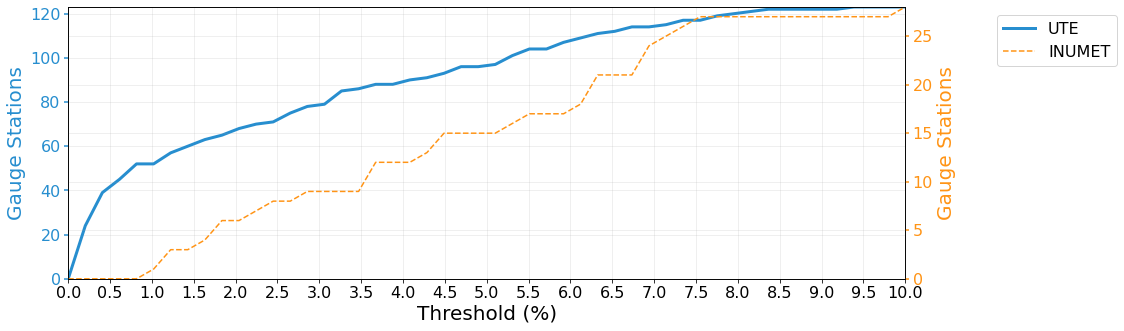

In [ ]:
# Init
fig, ax = init_plot(
            xticks=np.arange(0.0, 10.5, 0.5)
          )

# UTE --------------------------------------------------------------------------
_performance_ute.plot( ax=ax, 
                       y='count_below_threshold_estaciones',
                      )
set_ax(fig, ax, gauge='ute', ylabel='Gauge Stations',label='UTE')

# INUMET -----------------------------------------------------------------------
_twin = ax.twinx()
_performance_inumet.plot( ax=_twin, 
                          y='count_below_threshold_estaciones',                       
                        )
set_ax(fig, _twin, gauge='inumet', ylabel='Gauge Stations',label='INUMET')

# Show 
show_plot(  fig,
            xlabel='Threshold (%)',
          )

### Gauge Stations- Threshold - UTE/SBPP

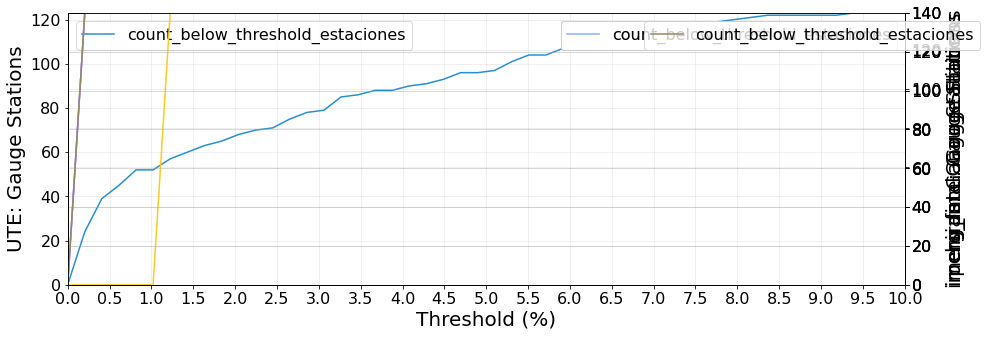

In [ ]:
fig, ax = init_plot(
            xticks=np.arange(0.0, 10.5, 0.5)
          )

# UTE --------------------------------------------------------------------------
_performance_ute.plot(ax=ax, 
                       y='count_below_threshold_estaciones',
                      #  label='Stations/Threshold',
                       c=get_rbg_color(global_colors['ute']))
ax.set_ylabel('UTE: Gauge Stations')

# SBPP -----------------------------------------------------------------------
sbpp_df = {
    'chirps': _performance_ute_chirps,
    'imerg_final': _performance_ute_imerg_final,
    'imerg_late': _performance_ute_imerg_late,
    'persiann': _performance_ute_persiann,
}
for sbpp in ['chirps','imerg_final','imerg_late','persiann']:
  _twin = ax.twinx()
  
  __df = sbpp_df[sbpp] 

  __df.plot(ax=_twin, 
                        y='count_below_threshold_estaciones',
                        #  label='Stations/Threshold',
                        c=get_rbg_color(global_colors[sbpp]))
  _twin.set_ylabel(sbpp+': Gauge Stations')

show_plot(  fig,
            # title='UTE: Stations below threshold', 
            xlabel='Threshold (%)',# ylabel='Gauge Stations',
          )

### Gauge Stations- Threshold - INUMET/SBPP

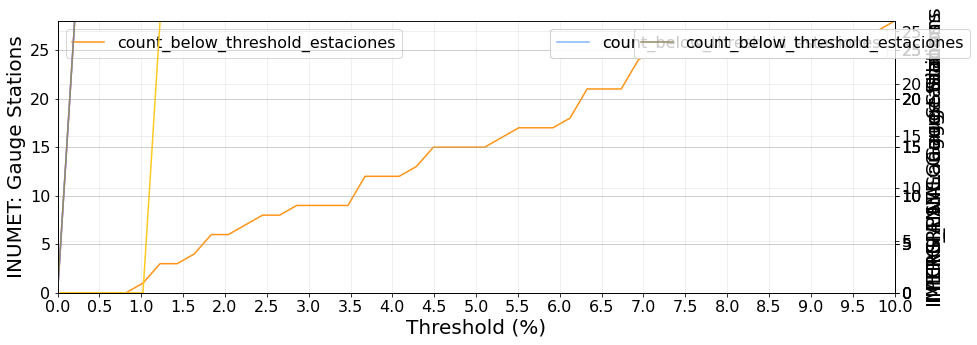

In [ ]:
fig, ax = init_plot(
            xticks=np.arange(0.0, 10.5, 0.5)
          )

# INUMET --------------------------------------------------------------------------
_performance_inumet.plot(ax=ax, 
                       y='count_below_threshold_estaciones',
                      #  label='Stations/Threshold',
                       c=get_rbg_color(global_colors['inumet']))
ax.set_ylabel('INUMET: Gauge Stations')

# SBPP -----------------------------------------------------------------------
sbpp_df = {
    'chirps': _performance_inumet_chirps,
    'imerg_final': _performance_inumet_imerg_final,
    'imerg_late': _performance_inumet_imerg_late,
    'persiann': _performance_inumet_persiann,
}
for sbpp in ['chirps','imerg_final','imerg_late','persiann']:
  _twin = ax.twinx()
  
  __df = sbpp_df[sbpp] 

  __df.plot(ax=_twin, 
                        y='count_below_threshold_estaciones',
                        #  label='Stations/Threshold',
                        c=get_rbg_color(global_colors[sbpp]))
  _twin.set_ylabel(sbpp.upper()+': Gauge Stations')

show_plot(  fig,
            # title='inumet: Stations below threshold', 
            xlabel='Threshold (%)',# ylabel='Gauge Stations',
          )

# Analisis 

## UTE

In [ ]:
threshould_perc_ute = .5 / 100  
_below_threshold_ute, _above_threshold_ute = getEstacionesByPercentageTreshold(df_ute_accum_monthly, gauge='ute', threshould_perc=threshould_perc_ute)

In [ ]:
_below_threshold_ute.shape, _above_threshold_ute.shape 

# 42 estaciones tiene como maximo un 0.5% de datos faltantes
# 98 estaciones tiene como minimo un 0.5% de datos faltantes

((42,), (98,))

In [ ]:
# 42 estaciones tiene como maximo un 0.5% de datos faltantes
_below_threshold_ute

0                      Aceguá
3                      Ansina
4          Arbolito (Pereira)
9                  Blanquillo
14                    Cardona
16              Carlos Reyles
19                  Centurión
22                Cerro Chato
23             Cerro Colorado
26        Cerro de la Cuentas
30        Col. Rossell y Rius
32        Cuchilla del Carmen
39               E.M. Durazno
40                  E.M. Melo
41              E.M. Mercedes
42                E.M. Palmar
43     E.M. Paso de los Toros
44                E.M. Rivera
50                  El Aguila
64                       Goñi
69                  La Paloma
70                  La Puente
79                   Marincho
82                   Moirones
83                 Nico Perez
85                   Palmitas
88               Paso Ataques
96            Paso de la Cruz
102      Paso de los Mellizos
109                    Pintos
110            Polanco del Yi
111       Porongos - Aviación
112             Pueblo Noblia
118       

In [ ]:
# ARMAR UNA CARPETA DE DATOS FINALES
df_ute_below_threshold = df_ute.query('estacion in @_below_threshold_ute')
file_name = dir_drive_db+"UTE/stage04_ute_sbpp_report_2001_2020_0.5_percentage.csv"
df_ute_below_threshold.to_csv(file_name)

df_ute.shape, df_ute_below_threshold.shape

((1022700, 23), (306810, 23))

In [ ]:
# Get Gauge Stations
df_ute_below_threshold_unique = df_ute_below_threshold.reset_index(drop=True)[['estacion','lat','lon']].drop_duplicates()

In [ ]:
fig = px.scatter_mapbox(df_ute_below_threshold_unique, 
                        lat="lat", 
                        lon="lon",  
                        zoom=6,
                        )
 
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### Calcular

##### Monthly

In [ ]:
# Gauge Stations with a maximum loss of 5% 
df_ute_accum_monthly_below_threshold = df_ute_accum_monthly.query('estacion in @_below_threshold_ute')
df_ute_accum_monthly_below_threshold.sort_index(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:6402: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
display(df_ute_accum_monthly.shape, df_ute_accum_monthly_below_threshold.shape)
df_ute_accum_monthly_below_threshold[:3]

(33600, 11)

(10080, 11)

accum_month_ute  accum_month_imerg_final  \
estacion year month                                             
Aceguá   2001 1                 88.0               139.344700   
              2                106.0                90.056128   
              3                294.0               224.554079   

                     accum_month_imerg_late  accum_month_chirps  \
estacion year month                                               
Aceguá   2001 1                  154.222040          108.617170   
              2                   69.195222          109.893551   
              3                  188.941899          198.503364   

                     accum_month_persiann  count_month  missing_month_ute  \
estacion year month                                                         
Aceguá   2001 1                       0.0           31                  0   
              2                       0.0           28                  0   
              3                       0.0           31                  0   

                     missing_month_imerg_final  missing_month_imerg_late  \
estacion year month                                                        
Aceguá   2001 1                              0                         0   
              2                              0                         0   
              3                              0                         0   

                     missing_month_chirps  missing_month_persiann  
estacion year month                                                
Aceguá   2001 1                         1                      31  
              2                         1                      28  
              3                         0                      31

##### Performance

In [ ]:
# Calcule Contingency metrics?
df_ute_performance = calcutePerformance(df_ute_accum_monthly_below_threshold,gauge='ute', r_from=10, r_to=400, step=10)
df_ute_performance

satellite       pod       far  threshold
0   imerg_final  0.998570  0.021807         10
1    imerg_late  0.997039  0.020171         10
2        chirps  0.998570  0.027352         10
3      persiann  0.975493  0.027387         10
0   imerg_final  0.996057  0.050107         20
..          ...       ...       ...        ...
3      persiann  0.597561  0.646209        380
0   imerg_final  0.605442  0.252101        390
1    imerg_late  0.789116  0.807947        390
2        chirps  0.469388  0.206897        390
3      persiann  0.605442  0.657692        390

[156 rows x 4 columns]

##### Metric

In [ ]:
# Calculate Global Accuracy metrics
df_ute_metrics = calculateAccuracyMetrics(df_ute_accum_monthly_below_threshold, gauge='ute')
df_ute_metrics

satellite        cc       rmse         rb
0  imerg_final  0.906979  38.097661  -7.052115
1   imerg_late  0.809044  91.190439 -29.544049
2       chirps  0.865620  44.196464  -2.080154
3     persiann  0.701693  74.295308  -3.805324

In [ ]:
# Calculate Monthly Accuracy Metrics
# df_ute_monthly_metrics = calcuteMontlyMetrics(df_ute_accum_monthly, gauge='ute')
df_ute_monthly_metrics = calcuteMontlyMetrics(df_ute_accum_monthly_below_threshold, gauge='ute')
df_ute_monthly_metrics[:5]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:6402: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



satellite        cc       rmse         rb  month month_name
0  imerg_final  0.869164  46.427868  -8.419768      1        JAN
1   imerg_late  0.717364  84.469984 -20.264346      1        JAN
2       chirps  0.825092  52.457586  -5.164005      1        JAN
3     persiann  0.666248  71.758192  -7.737707      1        JAN
0  imerg_final  0.894791  48.519490 -10.335937      2        FEB

##### Mean

In [ ]:
df_ute_accum_monthly_below_threshold_mean = df_ute_accum_monthly_below_threshold.reset_index().groupby(['month']).mean()
df_ute_accum_monthly_below_threshold_mean[:3]

year  accum_month_ute  accum_month_imerg_final  \
month                                                     
1      2010.5       114.638095               125.177774   
2      2010.5       131.502381               146.661189   
3      2010.5       119.458333               122.231305   

       accum_month_imerg_late  accum_month_chirps  accum_month_persiann  \
month                                                                     
1                  143.772691          120.880363            124.252381   
2                  173.064795          130.829797            157.438095   
3                  191.759817          119.728442            118.708333   

       count_month  missing_month_ute  missing_month_imerg_final  \
month                                                              
1            31.00           0.035714                        0.0   
2            28.25           0.058333                        0.0   
3            31.00           0.060714                        0.0   

       missing_month_imerg_late  missing_month_chirps  missing_month_persiann  
month                                                                          
1                           0.0                   0.2                0.738095  
2                           0.0                   0.1                0.672619  
3                           0.0                   0.2                0.738095

##### Acumulado

In [ ]:
df_ute_accum_monthly_below_threshold_sum = df_ute_accum_monthly_below_threshold.reset_index().groupby(['month']).sum()
df_ute_accum_monthly_below_threshold_sum[:3]

year  accum_month_ute  accum_month_imerg_final  \
month                                                      
1      1688820          96296.0            105149.329914   
2      1688820         110462.0            123195.398412   
3      1688820         100345.0            102674.296078   

       accum_month_imerg_late  accum_month_chirps  accum_month_persiann  \
month                                                                     
1               120769.060724       101539.504656              104372.0   
2               145374.427505       109897.029605              132248.0   
3               161078.245998       100571.891549               99715.0   

       count_month  missing_month_ute  missing_month_imerg_final  \
month                                                              
1            26040                 30                          0   
2            23730                 49                          0   
3            26040                 51                          0   

       missing_month_imerg_late  missing_month_chirps  missing_month_persiann  
month                                                                          
1                             0                   168                     620  
2                             0                    84                     565  
3                             0                   168                     620

#### PDF

In [ ]:
gauge = 'ute'
r = [0,50,100,150,200,250,300,400,500,600,10000,10000]
levels_ute = []
for idx, val in enumerate(r):
    if idx < len(r) - 1 :
      min = val
      max =  r[idx+1] 

      x = df_ute_accum_monthly_below_threshold
      x_ute      = x[ ( x['accum_month_'+gauge]>=min )       & ( x['accum_month_'+gauge]<max )]
      x_imerg_late  = x[ ( x['accum_month_imerg_late']>=min )   & ( x['accum_month_imerg_late']<max )]
      x_imerg_final = x[ ( x['accum_month_imerg_final']>=min )  & ( x['accum_month_imerg_final']<max )]
      x_chirps      = x[ ( x['accum_month_chirps']>=min )       & ( x['accum_month_chirps']<max )]
      x_persiann    = x[ ( x['accum_month_persiann']>=min )     & ( x['accum_month_persiann']<max )]
      
      
      # display([min, max, x_ute.shape[0], x_imerg_late.shape[0], x_imerg_final.shape[0], x_chirps.shape[0], x_persiann.shape[0]])
      levels_ute.append([min, max, x_ute.shape[0], x_imerg_late.shape[0], x_imerg_final.shape[0], x_chirps.shape[0], x_persiann.shape[0]])


levels_ute = pd.DataFrame(levels_ute, 
                      columns=['min','max',gauge,'imerg_late','imerg_final','chirps','persiann'],
                      # index = ['0-10','10-50','50-100','100-150','150-200','200-500','500-inf','borrar']
                      index = ['0-50','50-100','100-150','150-200','200-250','250-300','300-400','400-500','500-600','600-inf','borrar']
                      )


levels_ute = levels_ute[ levels_ute[gauge]>0 ]

In [ ]:
levels_ute[:3]

min  max   ute  imerg_late  imerg_final  chirps  persiann
0-50       0   50  2440        1644         1805    1535      2397
50-100    50  100  3095        2408         3178    3662      3376
100-150  100  150  2053        1893         2336    2393      1771

In [ ]:
levels_ute_sum = levels_ute.sum()
levels_ute_sum

min             2550
max            12550
ute            10080
imerg_late     10080
imerg_final    10080
chirps         10080
persiann       10080
dtype: int64

In [ ]:
levels_ute = levels_ute / levels_ute_sum[gauge]
levels_ute

min       max       ute  imerg_late  imerg_final    chirps  \
0-50     0.000000  0.004960  0.242063    0.163095     0.179067  0.152282   
50-100   0.004960  0.009921  0.307044    0.238889     0.315278  0.363294   
100-150  0.009921  0.014881  0.203671    0.187798     0.231746  0.237401   
150-200  0.014881  0.019841  0.110615    0.128869     0.122421  0.135516   
200-250  0.019841  0.024802  0.059921    0.093849     0.070139  0.063690   
250-300  0.024802  0.029762  0.034127    0.063988     0.043056  0.024405   
300-400  0.029762  0.039683  0.029266    0.068254     0.027480  0.015476   
400-500  0.039683  0.049603  0.009325    0.029960     0.008135  0.006448   
500-600  0.049603  0.059524  0.002579    0.015575     0.002183  0.001389   
600-inf  0.059524  0.992063  0.001389    0.009722     0.000496  0.000099   

         persiann  
0-50     0.237798  
50-100   0.334921  
100-150  0.175694  
150-200  0.102083  
200-250  0.056944  
250-300  0.034722  
300-400  0.033234  
400-500  0.014286  
500-600  0.006052  
600-inf  0.004266

## INUMET

In [ ]:
threshould_perc_inumet = 3 / 100  
_below_threshold_inumet, _above_threshold_inumet = getEstacionesByPercentageTreshold(df_inumet_accum_monthly, gauge='inumet', threshould_perc=threshould_perc_inumet)

In [ ]:
_below_threshold_inumet.shape, _above_threshold_inumet.shape 

#  9 estaciones tiene como maximo un 3% de datos faltantes
# 19 estaciones tiene como minimo un 3% de datos faltantes

((9,), (19,))

In [ ]:
# 9 estaciones tiene como maximo un 3% de datos faltantes
_below_threshold_inumet

0                  25 de Agosto
4                Cap. del Sauce
7             Colonia Miguelete
8                    Conchillas
11                      Florida
12    Manuel Artigas Mal Abrigo
17            Pueblo Centenario
22                  San Antonio
23                  San Jacinto
dtype: object

In [ ]:
# ARMAR UNA CARPETA DE DATOS FINALES
df_inumet_below_threshold = df_inumet.query('estacion in @_below_threshold_inumet')
file_name = dir_drive_db+"INUMET/stage04_inumet_sbpp_report_2001_2020_3_percentage.csv"
df_inumet_below_threshold.to_csv(file_name)

df_inumet.shape, df_inumet_below_threshold.shape

((204540, 23), (65745, 23))

In [ ]:
# Get Gauge Stations
df_inumet_below_threshold_unique = df_inumet_below_threshold.reset_index(drop=True)[['estacion','lat','lon']].drop_duplicates()

In [ ]:
fig = px.scatter_mapbox(df_inumet_below_threshold_unique, 
                        lat="lat", 
                        lon="lon",  
                        zoom=6,
                        )
 
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### Calcular

##### Monthly

In [ ]:
# Gauge Stations with a maximum loss of 5% 
df_inumet_accum_monthly_below_threshold = df_inumet_accum_monthly.query('estacion in @_below_threshold_inumet')
df_inumet_accum_monthly_below_threshold.sort_index(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:6402: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
display(df_inumet_accum_monthly.shape, df_inumet_accum_monthly_below_threshold.shape)
df_inumet_accum_monthly_below_threshold[:3]

(6720, 11)

(2160, 11)

accum_month_inumet  accum_month_imerg_final  \
estacion     year month                                                
25 de Agosto 2001 1                   157.0               201.447725   
                  2                   118.0               163.394205   
                  3                   198.5               187.319932   

                         accum_month_imerg_late  accum_month_chirps  \
estacion     year month                                               
25 de Agosto 2001 1                  246.725883          130.876624   
                  2                  286.255923           92.976690   
                  3                  132.728953          320.985133   

                         accum_month_persiann  count_month  \
estacion     year month                                      
25 de Agosto 2001 1                     170.0           31   
                  2                     268.0           28   
                  3                     158.0           31   

                         missing_month_inumet  missing_month_imerg_final  \
estacion     year month                                                    
25 de Agosto 2001 1                         1                          0   
                  2                         0                          0   
                  3                         0                          0   

                         missing_month_imerg_late  missing_month_chirps  \
estacion     year month                                                   
25 de Agosto 2001 1                             0                     1   
                  2                             0                     1   
                  3                             0                     0   

                         missing_month_persiann  
estacion     year month                          
25 de Agosto 2001 1                           0  
                  2                           0  
                  3                           0

##### Performance

In [ ]:
# Calcule Contingency metrics?
df_inumet_performance = calcutePerformance(df_inumet_accum_monthly_below_threshold,gauge='inumet', r_from=10, r_to=400, step=10)
df_inumet_performance

satellite       pod       far  threshold
0   imerg_final  0.999044  0.026083         10
1    imerg_late  0.994267  0.026660         10
2        chirps  0.999522  0.031033         10
3      persiann  1.000000  0.031019         10
0   imerg_final  0.993967  0.058123         20
..          ...       ...       ...        ...
3      persiann  0.818182  0.739130        380
0   imerg_final  0.578947  0.266667        390
1    imerg_late  0.947368  0.852459        390
2        chirps  0.263158  0.285714        390
3      persiann  0.789474  0.772727        390

[156 rows x 4 columns]

##### Metric

In [ ]:
# Calculate Global Accuracy metrics
df_inumet_metrics = calculateAccuracyMetrics(df_inumet_accum_monthly_below_threshold, gauge='inumet')
df_inumet_metrics

satellite        cc       rmse         rb
0  imerg_final  0.913697  34.067404  -7.298272
1   imerg_late  0.811575  93.394250 -32.611246
2       chirps  0.847590  43.339845  -1.428580
3     persiann  0.722345  73.158180 -14.876565

In [ ]:
# Calculate Monthly Accuracy Metrics
# df_inumet_monthly_metrics = calcuteMontlyMetrics(df_inumet_accum_monthly, gauge='inumet')
df_inumet_monthly_metrics = calcuteMontlyMetrics(df_inumet_accum_monthly_below_threshold, gauge='inumet')
df_inumet_monthly_metrics[:5]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:6402: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



satellite        cc       rmse         rb  month month_name
0  imerg_final  0.861950  43.533782  -5.438340      1        JAN
1   imerg_late  0.782206  84.500673 -28.440169      1        JAN
2       chirps  0.786274  52.551020   2.057214      1        JAN
3     persiann  0.693430  63.189181  -7.937610      1        JAN
0  imerg_final  0.884695  46.172317 -11.569451      2        FEB

##### Mean

In [ ]:
df_inumet_accum_monthly_below_threshold_mean = df_inumet_accum_monthly_below_threshold.reset_index().groupby(['month']).mean()
df_inumet_accum_monthly_below_threshold_mean[:3]

year  accum_month_inumet  accum_month_imerg_final  \
month                                                        
1      2010.5          113.456667               119.981678   
2      2010.5          121.442222               137.330621   
3      2010.5          114.777222               128.352320   

       accum_month_imerg_late  accum_month_chirps  accum_month_persiann  \
month                                                                     
1                  158.547979          111.169669            123.238889   
2                  187.994424          115.888198            168.027778   
3                  209.880268          123.908504            135.355556   

       count_month  missing_month_inumet  missing_month_imerg_final  \
month                                                                 
1            31.00              0.500000                        0.0   
2            28.25              0.494444                        0.0   
3            31.00              0.488889                        0.0   

       missing_month_imerg_late  missing_month_chirps  missing_month_persiann  
month                                                                          
1                           0.0                   0.2                     0.0  
2                           0.0                   0.1                     0.0  
3                           0.0                   0.2                     0.0

##### Acumulado

In [ ]:
df_inumet_accum_monthly_below_threshold_sum = df_inumet_accum_monthly_below_threshold.reset_index().groupby(['month']).sum()
df_inumet_accum_monthly_below_threshold_sum[:3]

year  accum_month_inumet  accum_month_imerg_final  \
month                                                        
1      361890             20422.2             21596.702079   
2      361890             21859.6             24719.511759   
3      361890             20659.9             23103.417545   

       accum_month_imerg_late  accum_month_chirps  accum_month_persiann  \
month                                                                     
1                28538.636296        20010.540351               22183.0   
2                33838.996366        20859.875614               30245.0   
3                37778.448208        22303.530726               24364.0   

       count_month  missing_month_inumet  missing_month_imerg_final  \
month                                                                 
1             5580                    90                          0   
2             5085                    89                          0   
3             5580                    88                          0   

       missing_month_imerg_late  missing_month_chirps  missing_month_persiann  
month                                                                          
1                             0                    36                       0  
2                             0                    18                       0  
3                             0                    36                       0

#### PDF

In [ ]:
gauge = 'inumet'
r = [0,50,100,150,200,250,300,400,500,600,10000,10000]
levels_inumet = []
for idx, val in enumerate(r):
    if idx < len(r) - 1 :
      min = val
      max =  r[idx+1] 

      x = df_inumet_accum_monthly_below_threshold
      x_inumet      = x[ ( x['accum_month_'+gauge]>=min )       & ( x['accum_month_'+gauge]<max )]
      x_imerg_late  = x[ ( x['accum_month_imerg_late']>=min )   & ( x['accum_month_imerg_late']<max )]
      x_imerg_final = x[ ( x['accum_month_imerg_final']>=min )  & ( x['accum_month_imerg_final']<max )]
      x_chirps      = x[ ( x['accum_month_chirps']>=min )       & ( x['accum_month_chirps']<max )]
      x_persiann    = x[ ( x['accum_month_persiann']>=min )     & ( x['accum_month_persiann']<max )]
      
      
      # display([min, max, x_inumet.shape[0], x_imerg_late.shape[0], x_imerg_final.shape[0], x_chirps.shape[0], x_persiann.shape[0]])
      levels_inumet.append([min, max, x_inumet.shape[0], x_imerg_late.shape[0], x_imerg_final.shape[0], x_chirps.shape[0], x_persiann.shape[0]])


levels_inumet = pd.DataFrame(levels_inumet, 
                      columns=['min','max',gauge,'imerg_late','imerg_final','chirps','persiann'],
                      # index = ['0-10','10-50','50-100','100-150','150-200','200-500','500-inf','borrar']
                      index = ['0-50','50-100','100-150','150-200','200-250','250-300','300-400','400-500','500-600','600-inf','borrar']
                      )


levels_inumet = levels_inumet[ levels_inumet[gauge]>0 ]

In [ ]:
levels_inumet[:3]

min  max  inumet  imerg_late  imerg_final  chirps  persiann
0-50       0   50     589         365          431     385       416
50-100    50  100     705         530          775     848       798
100-150  100  150     423         435          435     477       394

In [ ]:
levels_inumet_sum = levels_inumet.sum()
levels_inumet_sum

min             2550
max            12550
inumet          2160
imerg_late      2160
imerg_final     2160
chirps          2160
persiann        2160
dtype: int64

In [ ]:
levels_inumet = levels_inumet / levels_inumet_sum[gauge]
levels_inumet

min       max    inumet  imerg_late  imerg_final    chirps  \
0-50     0.000000  0.023148  0.272685    0.168981     0.199537  0.178241   
50-100   0.023148  0.046296  0.326389    0.245370     0.358796  0.392593   
100-150  0.046296  0.069444  0.195833    0.201389     0.201389  0.220833   
150-200  0.069444  0.092593  0.083796    0.123611     0.112963  0.124537   
200-250  0.092593  0.115741  0.059722    0.093056     0.059722  0.053704   
250-300  0.115741  0.138889  0.032407    0.051852     0.044444  0.018519   
300-400  0.138889  0.185185  0.020370    0.063426     0.016667  0.008333   
400-500  0.185185  0.231481  0.006481    0.030556     0.005556  0.002778   
500-600  0.231481  0.277778  0.001852    0.012963     0.000926  0.000463   
600-inf  0.277778  4.629630  0.000463    0.008796     0.000000  0.000000   

         persiann  
0-50     0.192593  
50-100   0.369444  
100-150  0.182407  
150-200  0.096296  
200-250  0.059259  
250-300  0.038426  
300-400  0.032407  
400-500  0.015741  
500-600  0.009722  
600-inf  0.003704

# PLOT 


In [ ]:

def plot_metrics(metric, ylim, yticks):

  # Init
  fig, axs = init_plot(
              figsize=[15,5],
              xticks=range(13)
            )

  # UTE --------------------------------------------------------------------------
  for key, grp in df_ute_monthly_metrics.groupby(['satellite']):
      _color = get_rbg_color(global_colors[key])
      _label = global_labels[key]       

      grp.plot(ax=axs, 
                    kind='line',  
                    x='month_name', y=metric,   
                    ) 
      set_ax(fig, axs, gauge='ute', ylabel=metric, color=_color, label=_label, ylim=ylim, yticks=yticks)
  
  set_tick(fig, axs, gauge='ute', ylabel='UTE '+str(metric).upper())


  # # INUMET -----------------------------------------------------------------------
  _twin = axs.twinx()
  for key, grp in df_inumet_monthly_metrics.groupby(['satellite']):
      _color = get_rbg_color(global_colors[key])
      _label = global_labels[key]        

      grp.plot(ax=_twin, 
                    kind='line',  
                    x='month_name', y=metric,   
                    ) 
      set_ax(fig, _twin, gauge='inumet', ylabel=metric, color=_color, label=_label, ylim=ylim, yticks=yticks)

  set_tick(fig, _twin, gauge='inumet', ylabel='INUMET '+str(metric).upper())

  # Show 
  show_plot(  fig,
              # title='UTE: Stations below threshold', 
              xlabel='',# ylabel='Gauge Stations',
            )

## Gauge-SBPP

### CC - Figure 2 b


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



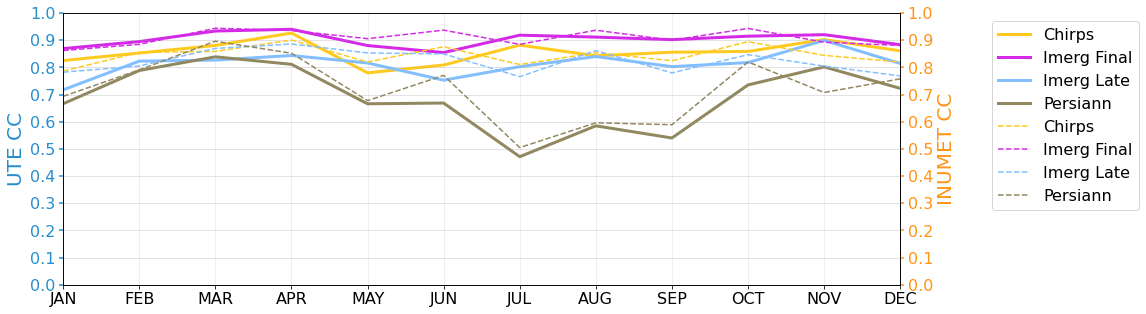

In [ ]:
plot_metrics('cc', ylim=[0,1], yticks=[0.0, 1.1, 0.1])

### RMSE


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



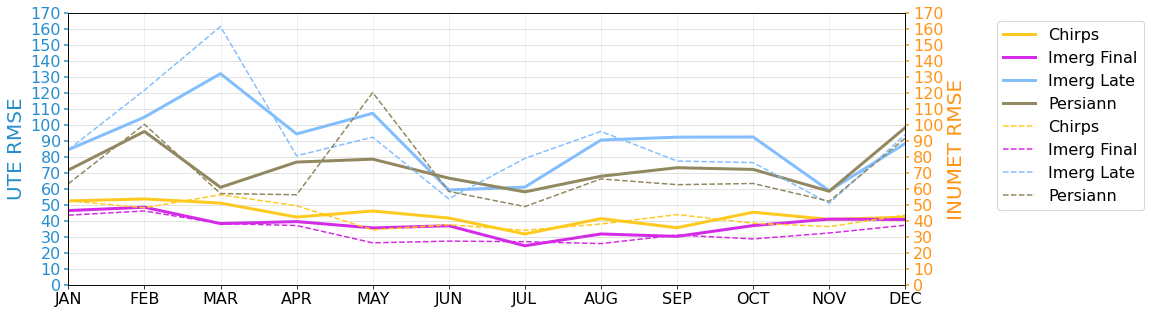

In [ ]:
plot_metrics('rmse', ylim=[0,170], yticks=[0.0, 180, 10])

### RB


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



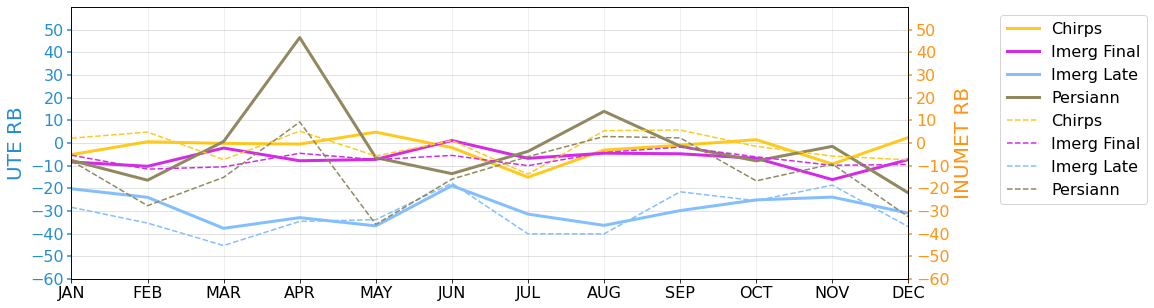

In [ ]:
plot_metrics('rb', ylim=[-60,60], yticks=[-60,60, 10])

### FAR - Figure 8 a

In [ ]:

def plot_metrics2(metric, ylim, yticks):

  # Init
  fig, axs = init_plot(
              figsize=[15,5],
              # xticks=range(13)
            )

  # UTE --------------------------------------------------------------------------
  for key, grp in df_ute_performance.groupby(['satellite']):
      _color = get_rbg_color(global_colors[key])
      _label = global_labels[key]       

      grp.plot(ax=axs, 
                    kind='line',  
                    x='threshold', y=metric,   
                    ) 
      set_ax(fig, axs, gauge='ute', ylabel=metric, color=_color, label=_label, ylim=ylim, yticks=yticks)
  
  set_tick(fig, axs, gauge='ute', ylabel='UTE '+str(metric).upper())


  # # INUMET -----------------------------------------------------------------------
  _twin = axs.twinx()
  for key, grp in df_inumet_performance.groupby(['satellite']):
      _color = get_rbg_color(global_colors[key])
      _label = global_labels[key]        

      grp.plot(ax=_twin, 
                    kind='line',  
                    x='threshold', y=metric,   
                    ) 
      set_ax(fig, _twin, gauge='inumet', ylabel=metric, color=_color, label=_label, ylim=ylim, yticks=yticks)

  set_tick(fig, _twin, gauge='inumet', ylabel='INUMET '+str(metric).upper())

  # Inset

  _color = get_rbg_color(global_colors['ute'])
  if metric == 'far':
    axins = axs.inset_axes([0.05, 0.74, 0.15, 0.15]) 
  else:
    axins = axs.inset_axes([0.05, 0.14, 0.15, 0.15]) 
  axins.set_title('UTE Rainfall')
  df_ute_accum_monthly_below_threshold['accum_month_ute'].hist(ax=axins, color=_color,  bins=100,grid=False)

  _color = get_rbg_color(global_colors['inumet'])
  if metric == 'far':
    axins = axs.inset_axes([0.25, 0.74, 0.15, 0.15]) 
  else:
    axins = axs.inset_axes([0.25, 0.14, 0.15, 0.15]) 
  axins.set_title('INUMET Rainfall')
  df_inumet_accum_monthly_below_threshold['accum_month_inumet'].hist(ax=axins, color=_color,  bins=100,grid=False)



  # Show 
  show_plot(  fig,
              # title='UTE: Stations below threshold', 
              xlabel='',# ylabel='Gauge Stations',
            )

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



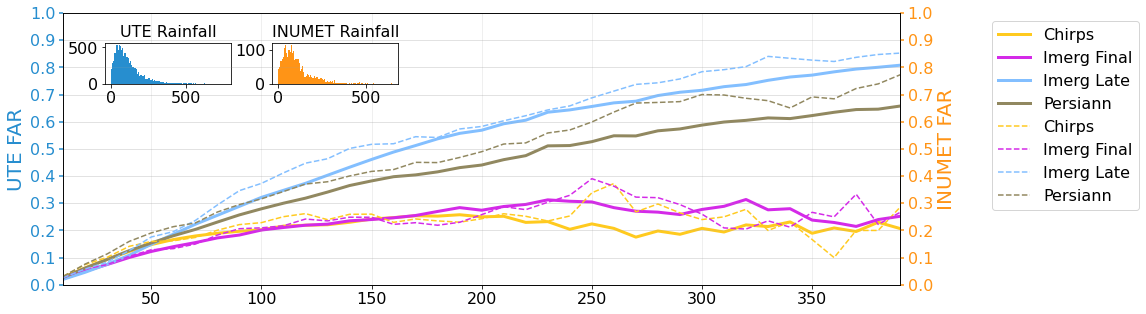

In [ ]:
plot_metrics2('far', ylim=[0,1], yticks=[0.0, 1.1, 0.1])

### POD - Figure 8 b

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



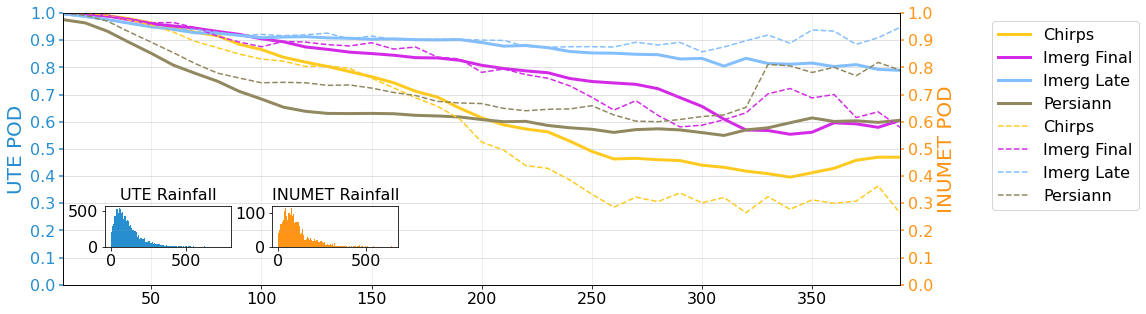

In [ ]:
plot_metrics2('pod', ylim=[0,1], yticks=[0.0, 1.1, 0.1])

## SBPP - CC/RMSE/RB


In [ ]:
def fx_metrics(grp, axs, gauge):
  # CC --------------------------------------------------------------------------
  metric = 'cc'
  _color = get_rbg_color(global_colors[metric])
  _label = global_labels[metric]       
  _ylim = [0,1]
  _yticks = [0,1.1,0.1]

  grp.plot(ax=axs, 
                kind='line',  
                x='month_name', y=metric,   
                ) 
  set_ax(fig, axs, gauge=gauge, ylabel=metric, color=_color, label=_label, ylim=_ylim, yticks=_yticks)

  set_tick(fig, axs, gauge=gauge, color=_color, ylabel=str(metric).upper())

  for metric in [ 'rmse', 'rb']:
    # Twin
    _twin = axs.twinx()

    _color = get_rbg_color(global_colors[metric])
    _label = global_labels[metric]       
    
    grp.plot(ax=_twin, 
                  kind='line',  
                  x='month_name', y=metric,   
                  ) 
    
    if metric == 'rmse':
        _ylim = [0,150]
        _yticks = [0,150,10]
    else:
        _ylim = [-60,60]
        _yticks = [-60,60,10]
        _twin.spines['right'].set_position(('axes', 1.1)) 

    set_ax(fig, _twin, gauge=gauge, ylabel=metric, color=_color, label=_label, ylim=_ylim, yticks=_yticks)

    set_tick(fig, _twin, gauge=gauge, color=_color, ylabel=str(metric).upper())



/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



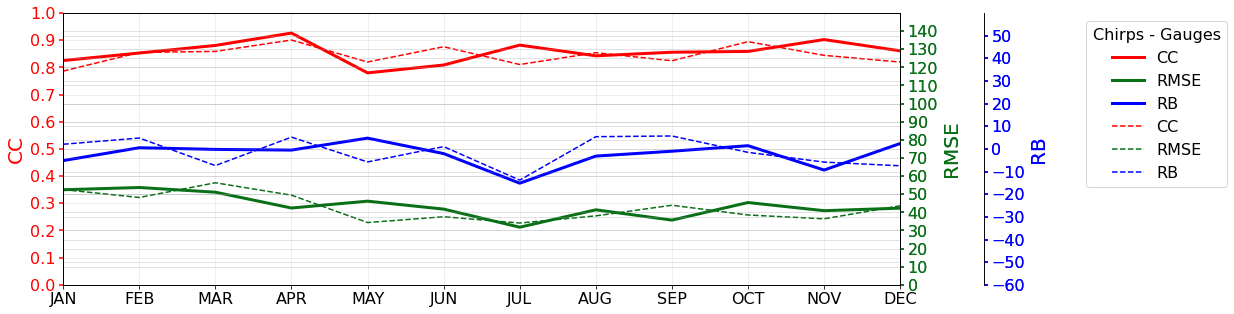

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



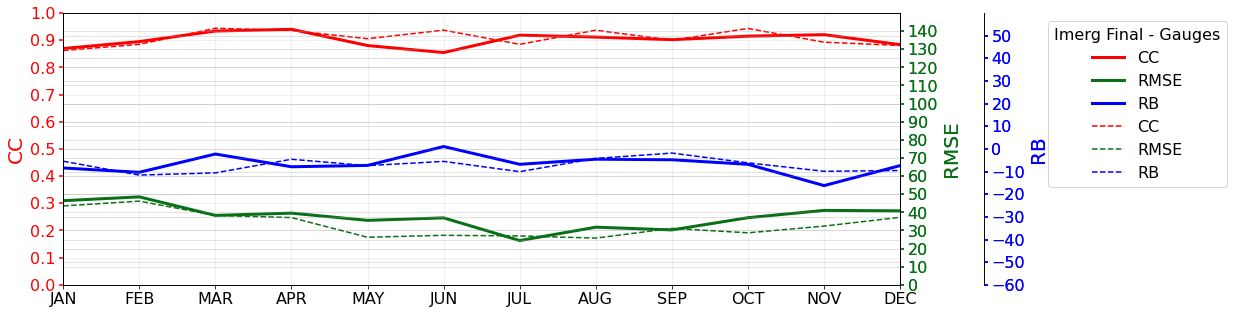

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



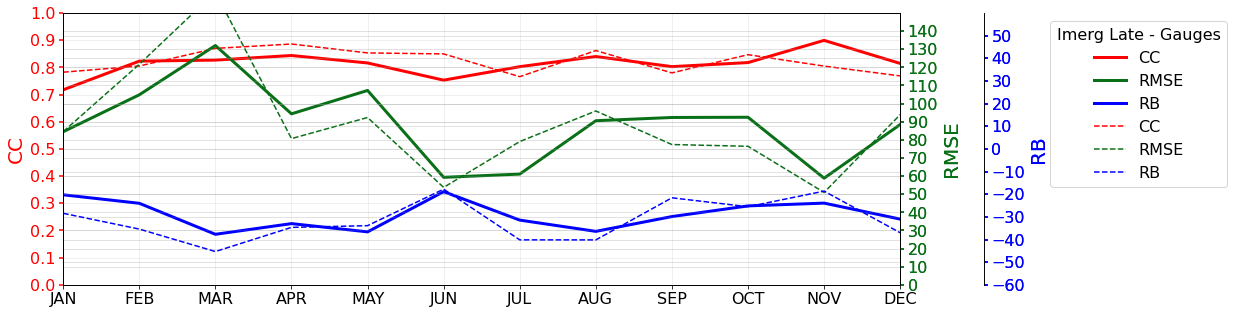

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



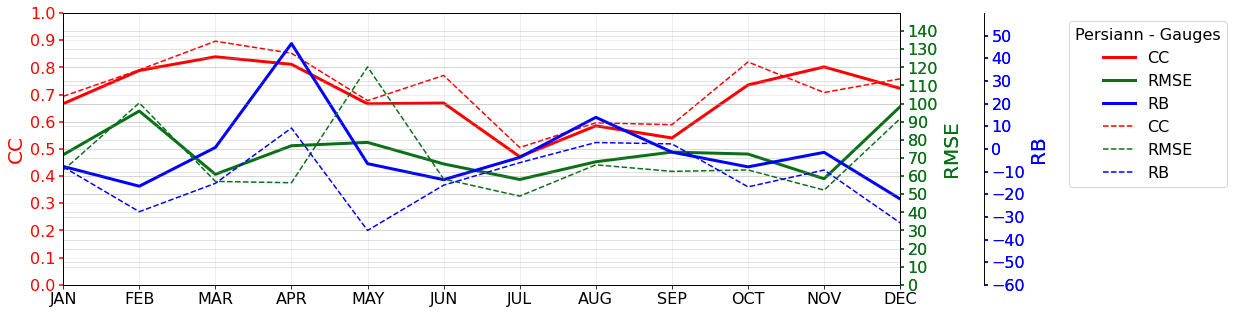

In [ ]:
for satellite, grp in df_ute_monthly_metrics.groupby(['satellite']):
  # Init Plot
  fig, axs = init_plot(
              figsize=[15,5],
              xticks=range(13)
            )
  fx_metrics(grp, axs, gauge='ute')

  # inumet
  df_x = df_inumet_monthly_metrics.groupby(['satellite'])
  grp_inumet = df_x.get_group(satellite) 
  fx_metrics(grp_inumet, axs, gauge='inumet')
 
 

  # Show Plot
  show_plot(  fig, legend_title=global_labels[satellite]+' - Gauges',
              xlabel='', bbox_to_anchor=[1.4, 1]
            )

## Histogram

### UTE

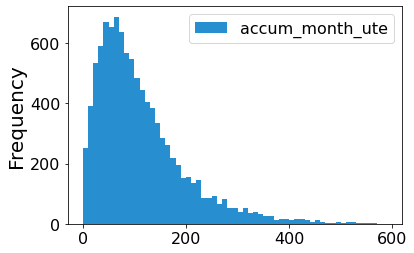

In [ ]:
_color = get_rbg_color(global_colors['ute'])
df_ute_accum_monthly_below_threshold.plot(kind='hist', y='accum_month_ute',color=_color, bins=np.arange(0,600,10))

### INUMET

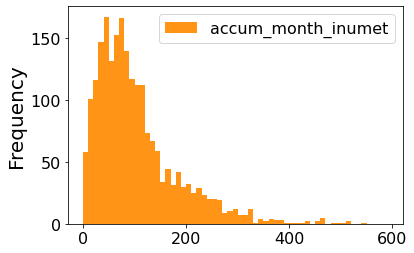

In [ ]:
_color = get_rbg_color(global_colors['inumet'])
df_inumet_accum_monthly_below_threshold.plot(kind='hist', y='accum_month_inumet', color=_color, bins=np.arange(0,600,10))

## Mean

####UTE

###### Figure 2 a

In [ ]:
df_ute_accum_monthly_below_threshold_mean.columns

Index(['year', 'accum_month_ute', 'accum_month_imerg_final',
       'accum_month_imerg_late', 'accum_month_chirps', 'accum_month_persiann',
       'count_month', 'missing_month_ute', 'missing_month_imerg_final',
       'missing_month_imerg_late', 'missing_month_chirps',
       'missing_month_persiann'],
      dtype='object')

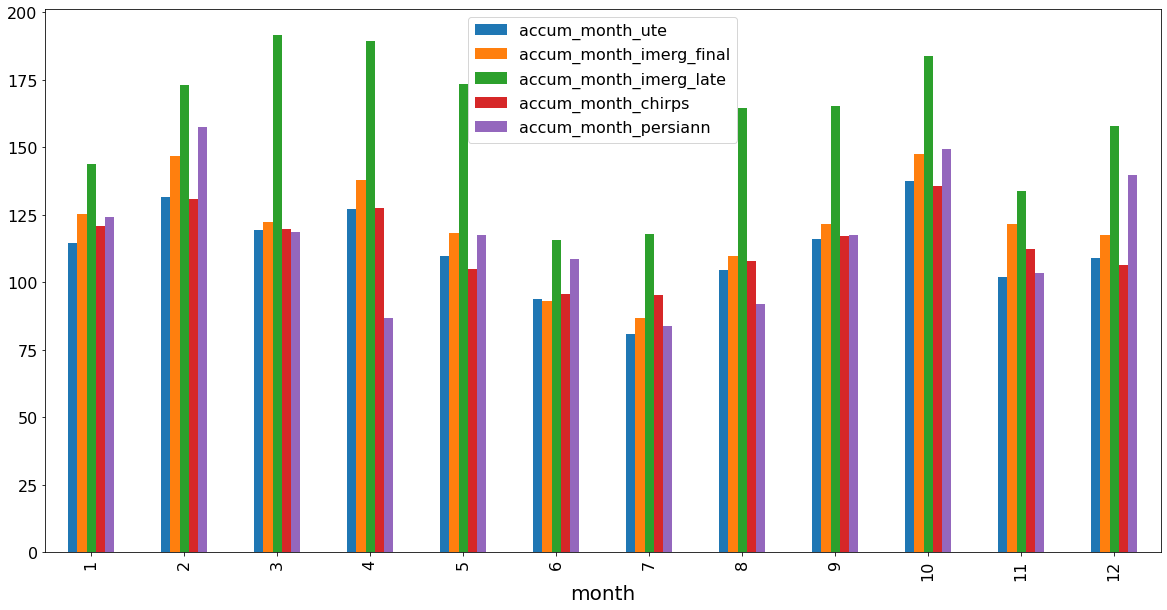

In [ ]:
# df_ute_accum_monthly_below_threshold_mean.shape
_cols = ['accum_month_ute', 'accum_month_imerg_final',
       'accum_month_imerg_late', 'accum_month_chirps', 'accum_month_persiann']
fig, axs = plt.subplots(figsize=(20,10))
df_ute_accum_monthly_below_threshold_mean.plot(ax=axs, kind='bar', y=_cols)

###### Figure 2 a - SUM

In [ ]:
df_ute_accum_monthly_below_threshold_sum.columns

Index(['year', 'accum_month_ute', 'accum_month_imerg_final',
       'accum_month_imerg_late', 'accum_month_chirps', 'accum_month_persiann',
       'count_month', 'missing_month_ute', 'missing_month_imerg_final',
       'missing_month_imerg_late', 'missing_month_chirps',
       'missing_month_persiann'],
      dtype='object')

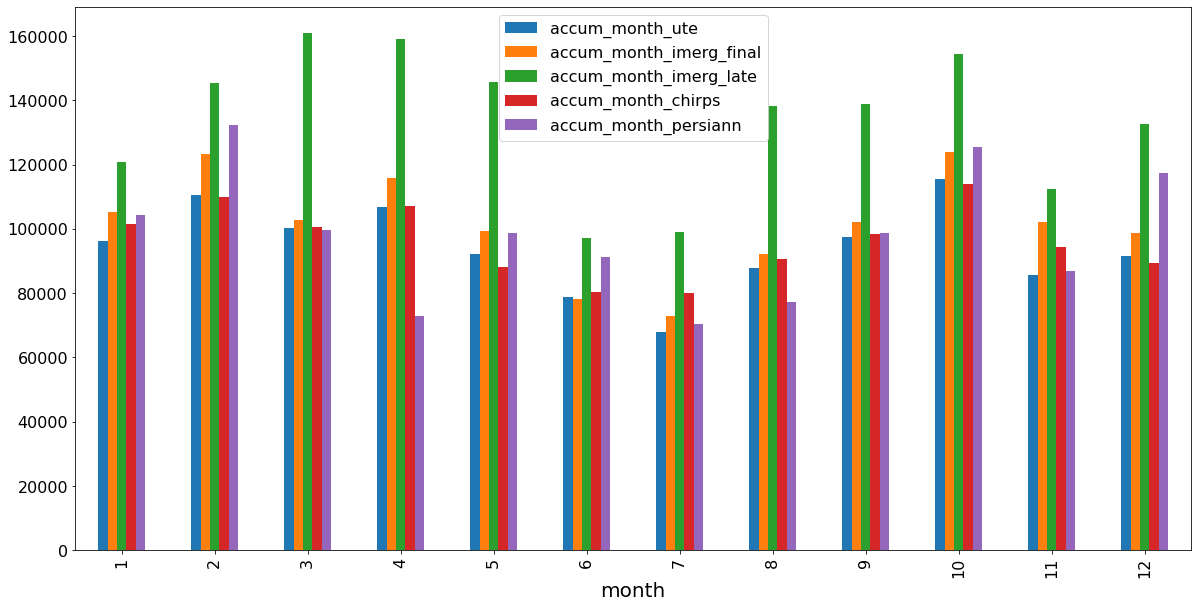

In [ ]:
# df_ute_accum_monthly_below_threshold_mean.shape
_cols = ['accum_month_ute', 'accum_month_imerg_final',
       'accum_month_imerg_late', 'accum_month_chirps', 'accum_month_persiann']

fig, axs = plt.subplots(figsize=(20,10))
df_ute_accum_monthly_below_threshold_sum.plot(ax=axs, kind='bar', y=_cols)

#### INUMET

###### Figure 2 a

In [ ]:
df_inumet_accum_monthly_below_threshold_mean.columns

Index(['year', 'accum_month_inumet', 'accum_month_imerg_final',
       'accum_month_imerg_late', 'accum_month_chirps', 'accum_month_persiann',
       'count_month', 'missing_month_inumet', 'missing_month_imerg_final',
       'missing_month_imerg_late', 'missing_month_chirps',
       'missing_month_persiann'],
      dtype='object')

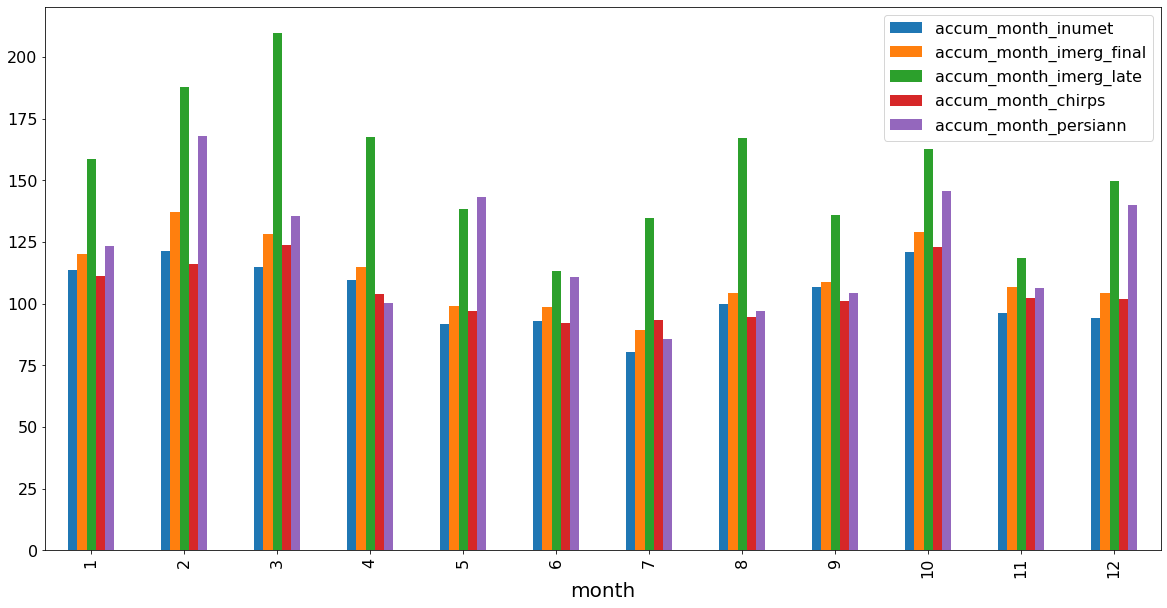

In [ ]:
# df_inumet_accum_monthly_below_threshold_mean.shape
_cols = ['accum_month_inumet', 'accum_month_imerg_final',
       'accum_month_imerg_late', 'accum_month_chirps', 'accum_month_persiann']
fig, axs = plt.subplots(figsize=(20,10))
df_inumet_accum_monthly_below_threshold_mean.plot(ax=axs, kind='bar', y=_cols)

###### Figure 2 a - SUM

In [ ]:
df_inumet_accum_monthly_below_threshold_sum.columns

Index(['year', 'accum_month_inumet', 'accum_month_imerg_final',
       'accum_month_imerg_late', 'accum_month_chirps', 'accum_month_persiann',
       'count_month', 'missing_month_inumet', 'missing_month_imerg_final',
       'missing_month_imerg_late', 'missing_month_chirps',
       'missing_month_persiann'],
      dtype='object')

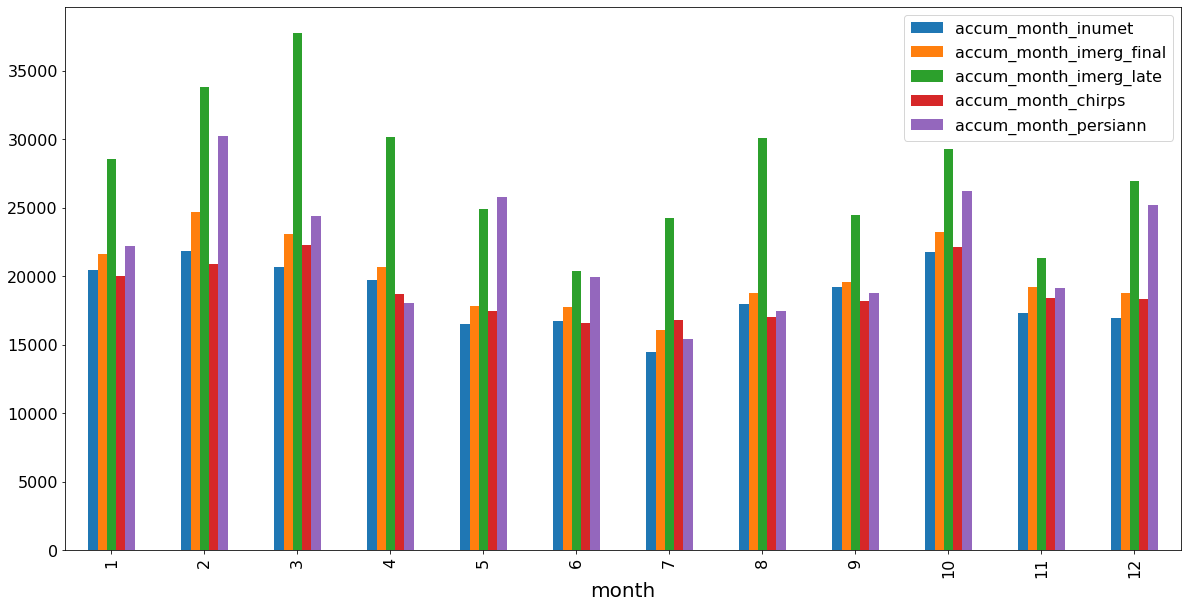

In [ ]:
# df_ute_accum_monthly_below_threshold_mean.shape
_cols = ['accum_month_inumet', 'accum_month_imerg_final',
       'accum_month_imerg_late', 'accum_month_chirps', 'accum_month_persiann'] 
fig, axs = plt.subplots(figsize=(20,10))
df_inumet_accum_monthly_below_threshold_sum.plot(ax=axs, kind='bar', y=_cols)

## PDF

### UTE

In [ ]:
levels_ute.columns

Index(['min', 'max', 'ute', 'imerg_late', 'imerg_final', 'chirps', 'persiann'], dtype='object')

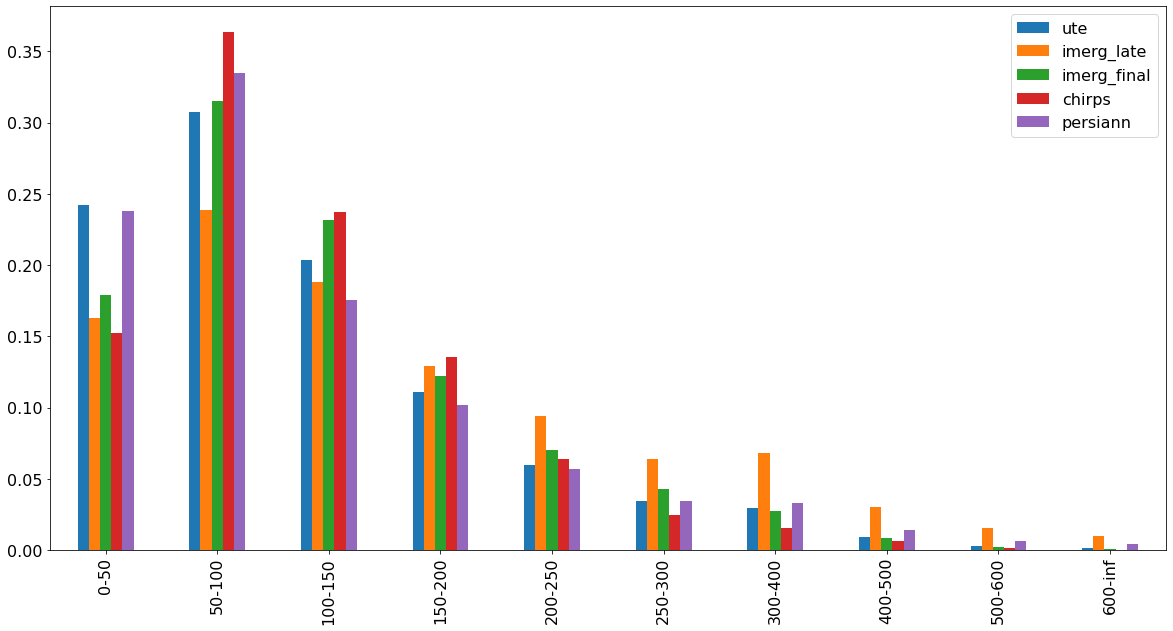

In [ ]:
_cols = ['ute', 'imerg_late', 'imerg_final', 'chirps','persiann'] 
fig, axs = plt.subplots(figsize=(20,10))
levels_ute.plot(ax=axs, kind='bar', y=_cols)


### INUMET

In [ ]:
levels_inumet.columns

Index(['min', 'max', 'inumet', 'imerg_late', 'imerg_final', 'chirps',
       'persiann'],
      dtype='object')

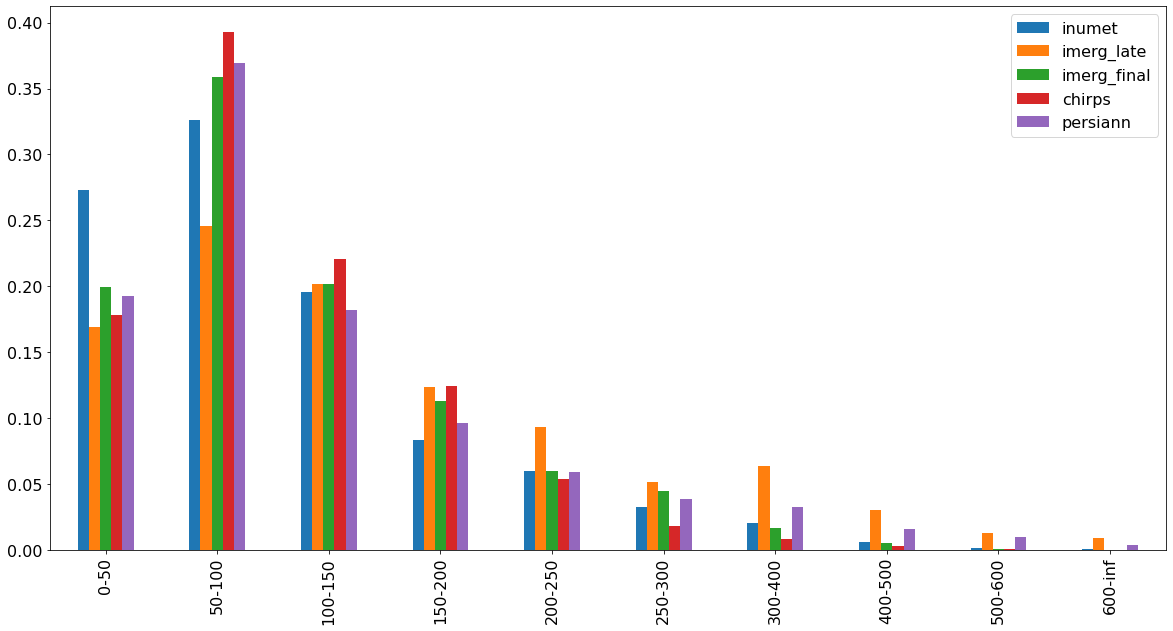

In [ ]:
_cols = ['inumet', 'imerg_late', 'imerg_final', 'chirps','persiann'] 
fig, axs = plt.subplots(figsize=(20,10))
levels_inumet.plot(ax=axs, kind='bar', y=_cols)

## Bar and BoxPlot

### UTE

In [ ]:
_cols = [ 'accum_month_ute', 'accum_month_imerg_final',
       'accum_month_imerg_late', 'accum_month_chirps', 'accum_month_persiann',
       ]
df_ute_ambt = df_ute_accum_monthly_below_threshold.reset_index()[['month']+_cols]
# df_x[:3]

In [ ]:
df_ute_ambt = pd.melt(df_ute_ambt,id_vars=['month'],value_vars=_cols,var_name='estacion', value_name='precipitacion')
# df_ute_ambt[:3]

(0.0, 250.0)

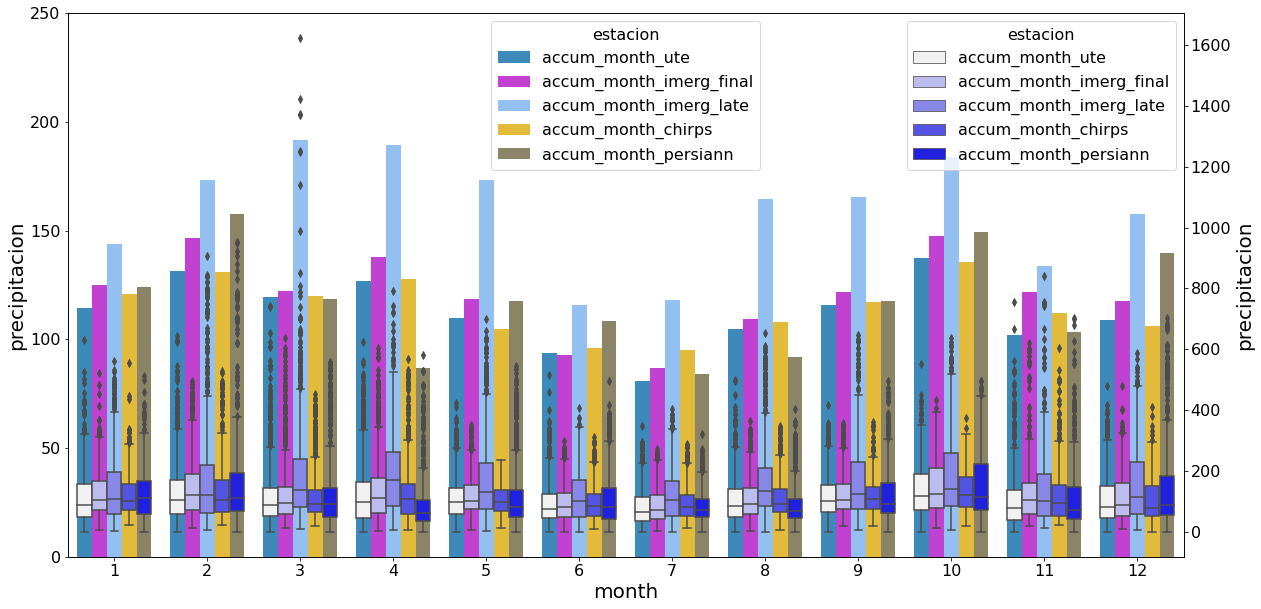

In [ ]:
df_ute_ambt_mean = df_ute_accum_monthly_below_threshold_mean.reset_index()[['month']+_cols]

df_ute_ambt_mean = pd.melt(df_ute_ambt_mean,id_vars=['month'],value_vars=_cols,var_name='estacion', value_name='precipitacion')

fig, axs = plt.subplots(figsize=(20,10))
  # palette=["C0", "C1", "k"] aaaaaaaaaaaa
_color = [get_rbg_color(global_colors['ute']),get_rbg_color(global_colors['imerg_final']),get_rbg_color(global_colors['imerg_late']),get_rbg_color(global_colors['chirps']),get_rbg_color(global_colors['persiann'])]
sns.barplot(ax=axs, x="month", y="precipitacion", hue="estacion", data=df_ute_ambt_mean, palette=_color)
_twin = axs.twinx()
sns.boxplot(ax=_twin, x="month", y="precipitacion", hue="estacion", data=df_ute_ambt, color='blue')

axs.set_ylim(0,250)

### INUMET

In [ ]:
_cols = [ 'accum_month_inumet', 'accum_month_imerg_final',
       'accum_month_imerg_late', 'accum_month_chirps', 'accum_month_persiann',
       ]
df_inumet_ambt = df_inumet_accum_monthly_below_threshold.reset_index()[['month']+_cols]
# df_x[:3]

In [ ]:
df_inumet_ambt = pd.melt(df_inumet_ambt,id_vars=['month'],value_vars=_cols,var_name='estacion', value_name='precipitacion')
# df_inumet_ambt[:3]

(0.0, 250.0)

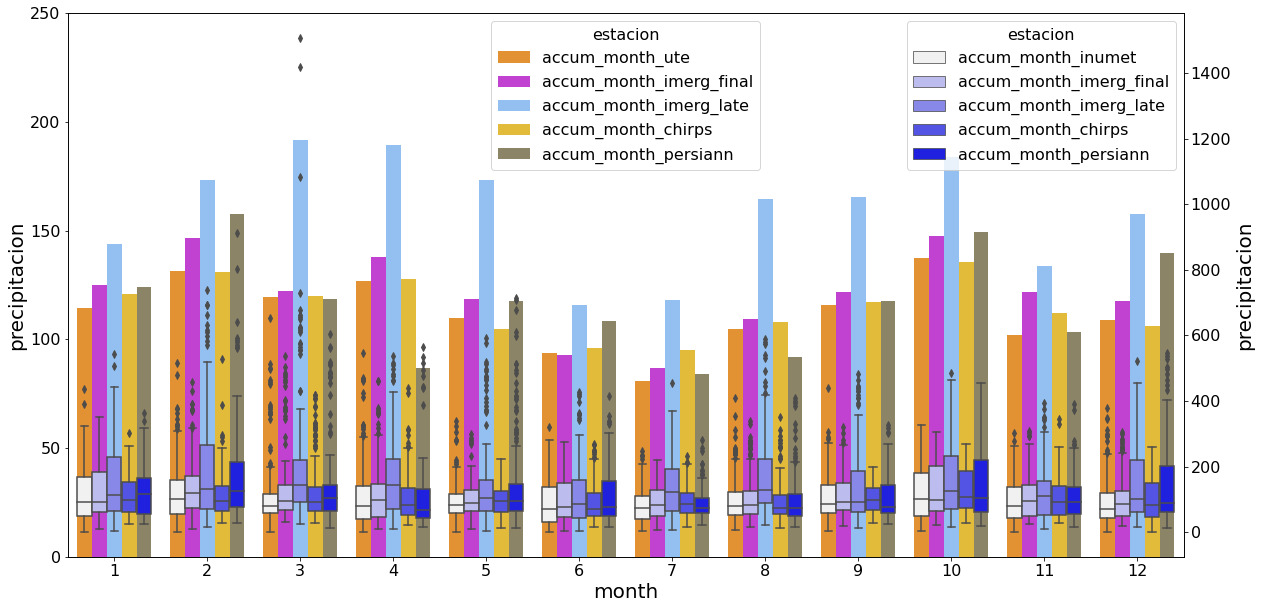

In [ ]:
df_inumet_ambt_mean = df_inumet_accum_monthly_below_threshold_mean.reset_index()[['month']+_cols]

df_inumet_ambt_mean = pd.melt(df_inumet_ambt_mean,id_vars=['month'],value_vars=_cols,var_name='estacion', value_name='precipitacion')

fig, axs = plt.subplots(figsize=(20,10))

_color = [get_rbg_color(global_colors['inumet']),get_rbg_color(global_colors['imerg_final']),get_rbg_color(global_colors['imerg_late']),get_rbg_color(global_colors['chirps']),get_rbg_color(global_colors['persiann'])]
sns.barplot(ax=axs, x="month", y="precipitacion", hue="estacion", data=df_ute_ambt_mean, palette=_color)
_twin = axs.twinx()
sns.boxplot(ax=_twin, x="month", y="precipitacion", hue="estacion", data=df_inumet_ambt, color='blue')

axs.set_ylim(0,250)

# Mapas Estacion

## Library

In [ ]:
!pip install geopandas contextily

In [ ]:
import geopandas
import geopandas as gpd
import contextily as ctx # for basemaps
from shapely.geometry import Point, LineString, Polygon
from matplotlib import pyplot as plt


In [ ]:
def x_calculateAccuracyMetrics(df_p, gauge):
  metrics = []
  for satellite in ['imerg_final', 'imerg_late', 'chirps','persiann']:
    _cc   = __cc(df_p[gauge], df_p[satellite])
    _rmse = __rmse(df_p[gauge], df_p[satellite])
    _rb   = __rb(df_p[gauge], df_p[satellite])  
    metrics.append([satellite, _cc, _rmse, _rb])

  return pd.DataFrame(metrics, columns =['satellite','cc','rmse', 'rb'])

In [ ]:
def x_calculateAccuracyPerformance(df_p, gauge, threshold):
  metrics = []
  for satellite in ['imerg_final', 'imerg_late', 'chirps','persiann']:
    _pod = __pod(df_p[gauge], df_p[satellite], threshold)
    _far = __far(df_p[gauge], df_p[satellite], threshold)
    
    metrics.append([satellite, _pod, _far])

  return pd.DataFrame(metrics, columns =['satellite','pod','far'])

In [ ]:
def x_df_metrics(dfx, gauge):  
  df_metrics = None

  for id, g in dfx.groupby('estacion'):
    # estacion, id, lat, lon 
    
    estacion, id, lat, lon = g['estacion'].values[0], g['id'].values[0], g['lat'].values[0], g['lon'].values[0]
    # display(estacion, id, lat, lon)

    _df_ute_metrics = x_calculateAccuracyMetrics(g, gauge=gauge)
    _df_ute_performance = x_calculateAccuracyPerformance(g, gauge, threshould_perc_ute)
    _df_ute_metrics[['pod','far']] = _df_ute_performance[['pod','far']]
    _df_ute_metrics[['estacion','id','lat','lon']] = [estacion, id, lat, lon]
    

    if df_metrics is None:
        df_metrics = _df_ute_metrics
    else:
        df_metrics = df_metrics.append(_df_ute_metrics)
    # _df_ute_monthly_metrics = calcuteMontlyMetrics(g, gauge=gauge)


    
  # df_metrics['geometry'] = 'POINT('+ df_metrics['lat'].astype(str) + ',' + df_metrics['lon'].astype(str) + ')'

  # display(df_metrics)

  # df_metrics.to_csv('estaciones_cc_rmse_rb_pod_far.csv')
  return df_metrics

## UTE

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning:

invalid value encountered in long_scalars




 --------------- chirps ---------------
cc


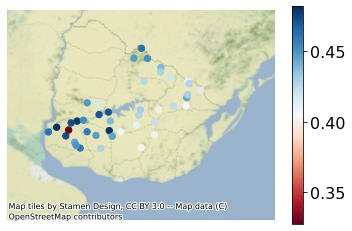

rmse


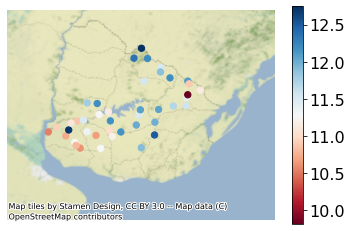

rb


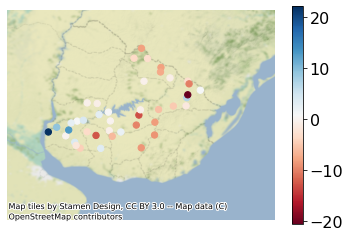

pod


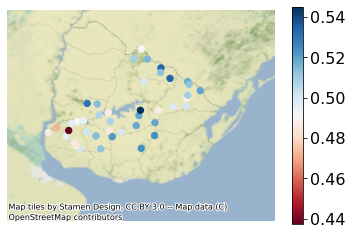

far


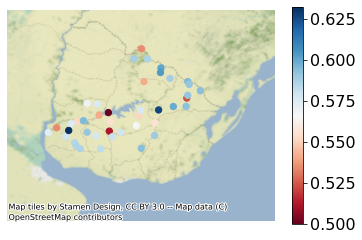


 --------------- imerg_final ---------------
cc


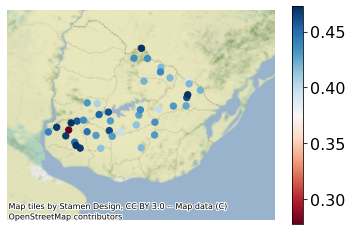

rmse


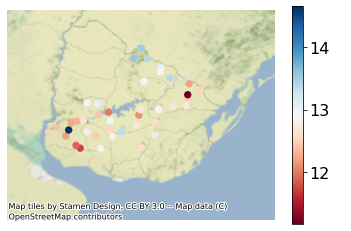

rb


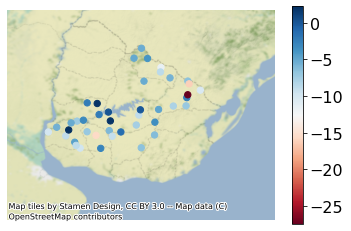

pod


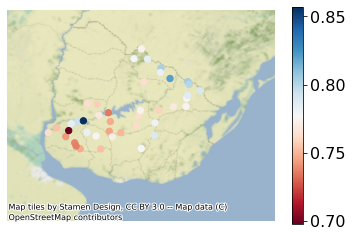

far


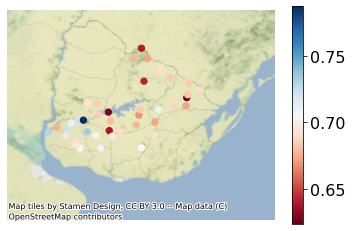


 --------------- imerg_late ---------------
cc


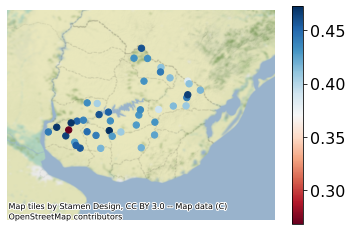

rmse


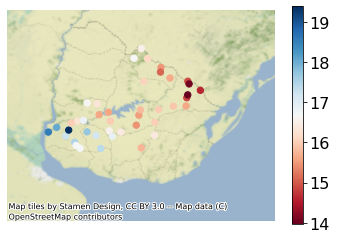

rb


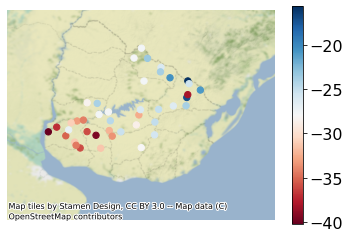

pod


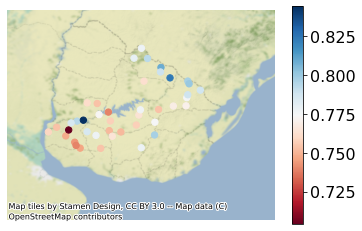

far


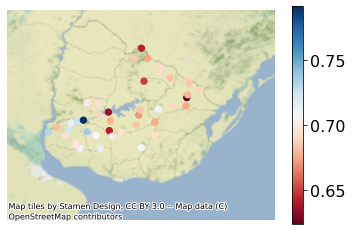


 --------------- persiann ---------------
cc


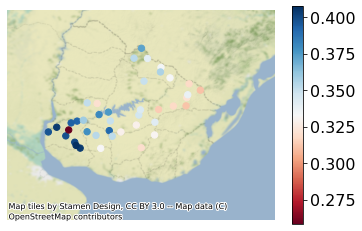

rmse


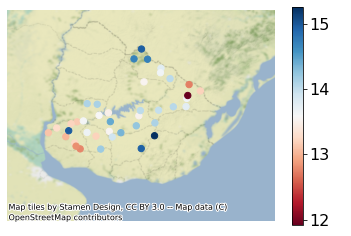

rb


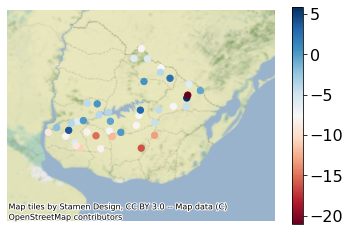

pod


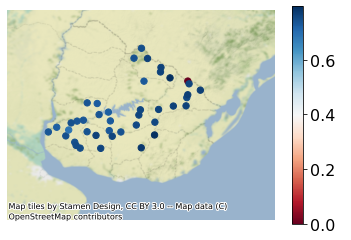

far


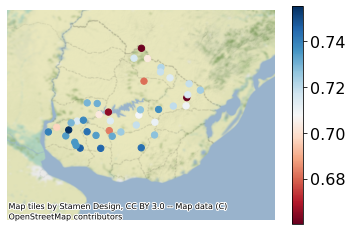

In [ ]:
df_metrics_ute = x_df_metrics(df_ute_below_threshold, 'ute')

for s in ['chirps','imerg_final','imerg_late','persiann']:
  df_metrics_s = df_metrics_ute[ df_metrics_ute['satellite'] == s]
  # display(df_metrics_s)
  print("\n ---------------",s,"---------------" )
  geodf_metrics = geopandas.GeoDataFrame(
      df_metrics_s, geometry=geopandas.points_from_xy(df_metrics_s.lon, df_metrics_s.lat))
  
  geodf_metrics.crs = "epsg:4326"
  geodf_metrics.to_crs(epsg=3857)

  for p in ['cc','rmse','rb','pod','far']:
    print(p)
    ax = geodf_metrics.plot( cmap='RdBu',  
                            column=p, 
                            markersize=40,
                            legend = True ) #, markersize='rmse')
    ax.set_xlim([-59.54461795, -51.561465053])
    ax.set_ylim([-36.028096999999995, -29.747346999999998]) 
    ax.axis('off') 
    ctx.add_basemap(ax=ax,  crs=geodf_metrics.crs, source=ctx.providers.Stamen.TerrainBackground)
    plt.show()

##INUMET


 --------------- chirps ---------------
cc


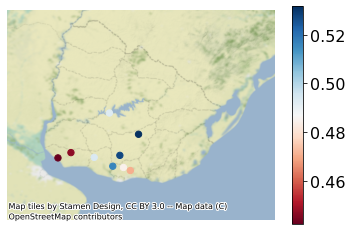

rmse


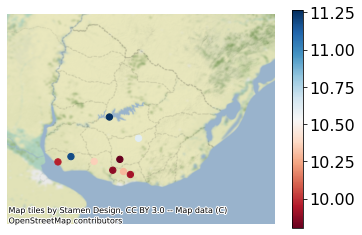

rb


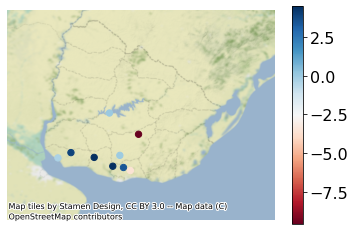

pod


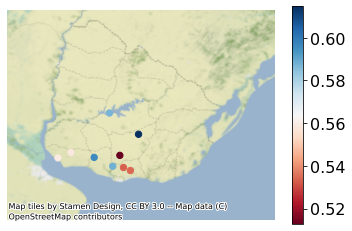

far


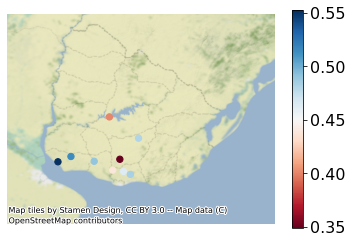


 --------------- imerg_final ---------------
cc


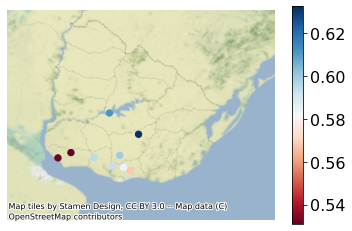

rmse


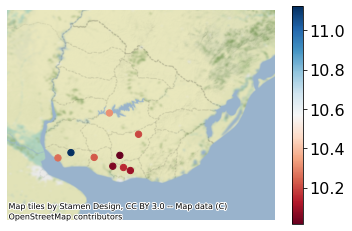

rb


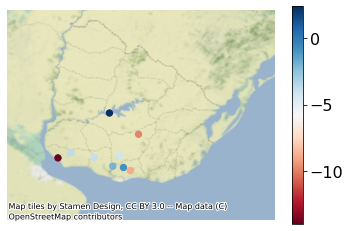

pod


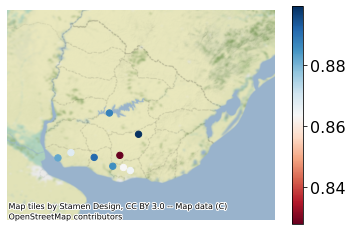

far


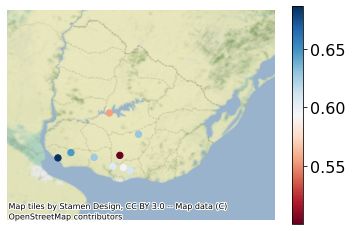


 --------------- imerg_late ---------------
cc


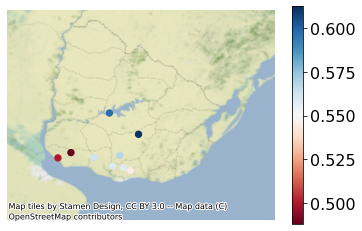

rmse


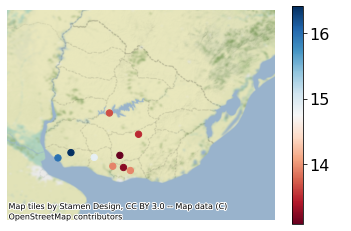

rb


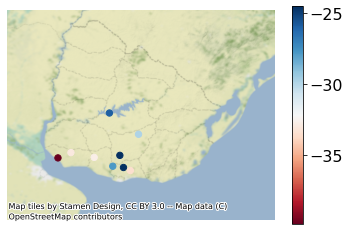

pod


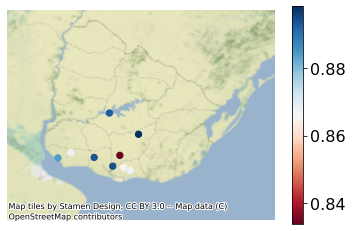

far


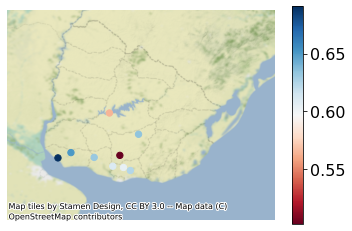


 --------------- persiann ---------------
cc


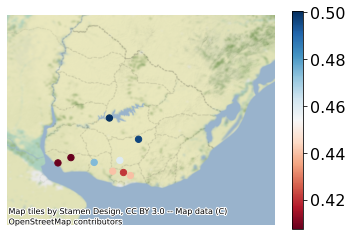

rmse


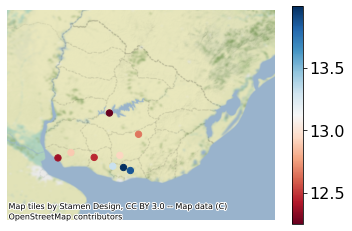

rb


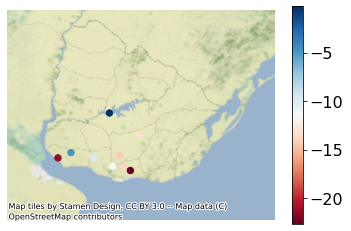

pod


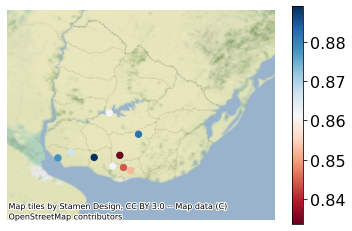

far


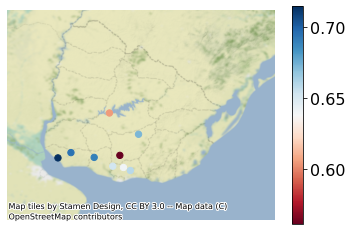

In [ ]:
df_metrics_inumet = x_df_metrics(df_inumet_below_threshold, 'inumet')

for s in ['chirps','imerg_final','imerg_late','persiann']:
  df_metrics_s = df_metrics_inumet[ df_metrics_inumet['satellite'] == s]
  # display(df_metrics_s)
  print("\n ---------------",s,"---------------" )
  geodf_metrics = geopandas.GeoDataFrame(
      df_metrics_s, geometry=geopandas.points_from_xy(df_metrics_s.lon, df_metrics_s.lat))
  
  geodf_metrics.crs = "epsg:4326"
  geodf_metrics.to_crs(epsg=3857)

  for p in ['cc','rmse','rb','pod','far']:
    print(p)
    ax = geodf_metrics.plot( cmap='RdBu',  
                            column=p, 
                            markersize=40,
                            legend = True ) #, markersize='rmse')
    ax.set_xlim([-59.54461795, -51.561465053])
    ax.set_ylim([-36.028096999999995, -29.747346999999998]) 
    ax.axis('off') 
    ctx.add_basemap(ax=ax,  crs=geodf_metrics.crs, source=ctx.providers.Stamen.TerrainBackground)
    plt.show()